In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import mne
import pickle 
import yaml
from tabulate import tabulate


from gait_modulation.utils.file_reader import MatFileReader
from gait_modulation.utils.data_processor import DataProcessor
from gait_modulation.viz import Visualise
from gait_modulation.utils.feature_extractor import FeatureExtractor

from gait_modulation.utils.utils import load_config

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


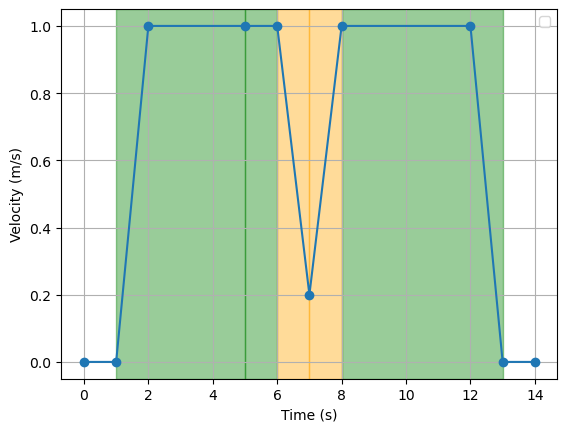

In [2]:
labels = ['Stopping', 'Trial Start', 'Normal Walking', 'VA Start Walking', 'Mod Start', 'Min Vel', 'Mod End', 'Normal Walking', 'Stopping', 'Trial End']
ts = [0, 1, 2, 5, 6, 7, 8, 12, 13, 14]
v = [0, 0, 1, 1, 1, 0.2, 1, 1, 0, 0]

# Define the regions and their colors
regions = [
    ('Normal Walking', 1, 5, 'green'),
    ('Normal Walking', 5, 6, 'green'),
    ('Modulation Start', 6, 7, 'orange'),
    ('Modulation End', 7, 8, 'orange'),
    ('Normal Walking', 8, 13, 'green'),
]

# Plot the regions as colored bars
for label, start, end, color in regions:
    plt.axvspan(start, end, color=color, alpha=0.4)
    # plt.text((start + end) / 2, max(v) + 0.1, label, ha='center', va='bottom', fontsize=10, rotation=45)

plt.plot(ts, v, marker='o')

plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
# plt.title('Abstract Representation of Patient Trial Velocity')
plt.legend()
plt.grid(True)
plt.show()


# Loading the data

In [3]:
config = load_config('gait_modulation/configs/data_preprocessing.yaml')

In [ ]:
# Handle multiple patients with nested directories.
root_directory = config['data']['root_directory']
subject_id = config['data']['subject_id']

mat_reader = MatFileReader(root_directory, subject_id)  # adjust the number of workers for parallelism later.

# Read all data from nested folders of multiple patients and sessions
all_data = mat_reader.read_data(max_workers=10)
n_sessions = len(all_data)

print(f"Number of sessions: {n_sessions}")

Loading: /Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/Rita/Gait_Modulation_Prediction_DATA/PW_HZ58/15-09-23/MAT/walking_sync_updated_3.mat
Loading: /Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/Rita/Gait_Modulation_Prediction_DATA/PW_HZ58/15-09-23/MAT/walking_sync_updated_4.mat
Loading: /Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/Rita/Gait_Modulation_Prediction_DATA/PW_HZ58/15-09-23/MAT/walking_sync_updated_6.mat
Loading: /Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/Rita/Gait_Modulation_Prediction_DATA/PW_US68/20-12-22/MAT/walking_sync_updated_1.mat
Loading: /Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/Rita/Gait_Modulation_Prediction_DATA/PW_US68/20-12-22/MAT/walking_sync_updated_2.mat
Loading: /Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/Rita/Gait_Modulat

In [5]:
for patient, sessions in all_data.items():
    print(f"Patient: {patient}, Sessions: {list(sessions.keys())}")

Patient: PW_HZ58, Sessions: ['walking_sync_updated_3', 'walking_sync_updated_4', 'walking_sync_updated_6']
Patient: PW_US68, Sessions: ['walking_sync_updated_1', 'walking_sync_updated_2', 'walking_sync_updated_3']
Patient: PW_HK59, Sessions: ['walking_sync_updated_1', 'walking_sync_updated_2', 'walking_sync_updated_3']
Patient: PW_FH57, Sessions: ['walking_sync_updated_1', 'walking_sync_updated_2', 'walking_sync_updated_3', 'walking_sync_updated_4']
Patient: PW_EM59, Sessions: ['walking_sync_updated_3']
Patient: PW_SN66, Sessions: ['walking_sync_updated_1', 'walking_sync_updated_2']
Patient: PW_SN61, Sessions: ['walking_sync_updated_1', 'walking_sync_updated_2', 'walking_sync_updated_3', 'walking_sync_updated_4']


Number of recording sessions per patient:
PW_HZ58: 3 sessions
PW_US68: 3 sessions
PW_HK59: 3 sessions
PW_FH57: 4 sessions
PW_EM59: 1 sessions
PW_SN66: 2 sessions
PW_SN61: 4 sessions

Session Counts Table:
+--------------+----------------------+
| Patient ID   |   Number of Sessions |
+==============+======================+
| PW_HZ58      |                    3 |
+--------------+----------------------+
| PW_US68      |                    3 |
+--------------+----------------------+
| PW_HK59      |                    3 |
+--------------+----------------------+
| PW_FH57      |                    4 |
+--------------+----------------------+
| PW_EM59      |                    1 |
+--------------+----------------------+
| PW_SN66      |                    2 |
+--------------+----------------------+
| PW_SN61      |                    4 |
+--------------+----------------------+


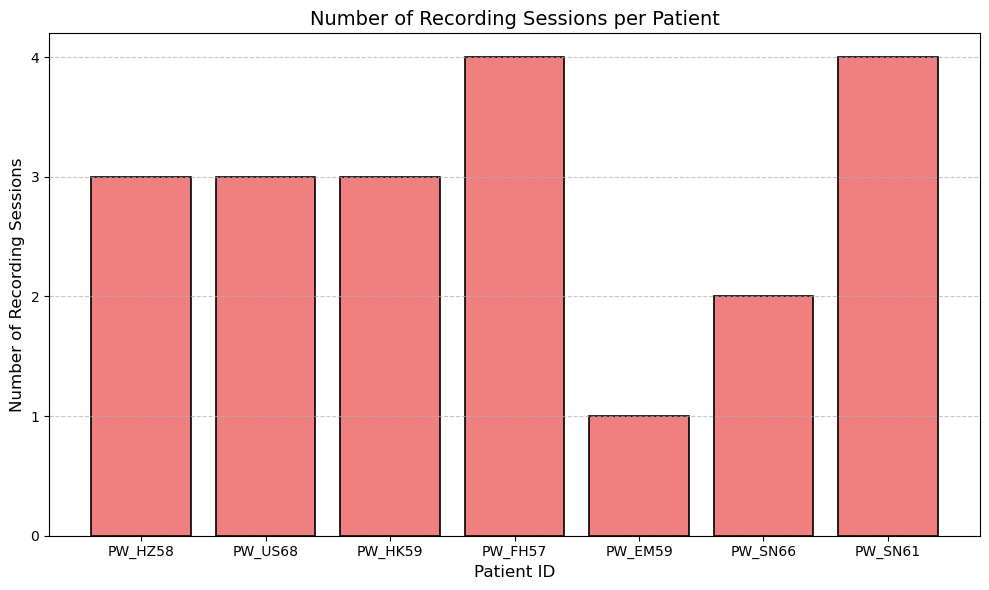

In [6]:
from tabulate import tabulate

# Count the number of recording sessions per patient
session_counts = {patient: len(sessions) for patient, sessions in all_data.items()}

# Print session counts
print("Number of recording sessions per patient:")
for patient, count in session_counts.items():
    print(f"{patient}: {count} sessions")

# Prepare tabular data
table_data = [[patient, count] for patient, count in session_counts.items()]
print("\nSession Counts Table:")
print(tabulate(table_data, headers=["Patient ID", "Number of Sessions"], tablefmt="grid"))

# Plot histogram of recording sessions
plt.figure(figsize=(10, 6))
plt.bar(
    session_counts.keys(),
    session_counts.values(),
    color="lightcoral",
    edgecolor="black",
    linewidth=1.2
)

# Add labels, title, and grid
plt.xlabel("Patient ID", fontsize=12)
plt.ylabel("Number of Recording Sessions", fontsize=12)
plt.title("Number of Recording Sessions per Patient", fontsize=14)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(range(0, max(session_counts.values()) + 1), fontsize=10)  # Integer ticks on y-axis
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

save_path ='results/figures/processed_data'
os.makedirs(save_path, exist_ok=True)
fig_name = 'session_counts'
plt.savefig(os.path.join(save_path, fig_name + '.png'))
plt.show()

In [7]:
d = all_data['PW_SN61']['walking_sync_updated_1']['hdr_LFP']

first_subject = list(all_data.keys())[0]
first_session = list(all_data[list(all_data.keys())[0]].keys())[0]
first_data = all_data[first_subject][first_session]

In [8]:
# Pick any subject/session to extract common meta data e.g. the first one
first_subject = list(all_data.keys())[0]
first_session = list(all_data[list(all_data.keys())[0]].keys())[0]
first_data = all_data[first_subject][first_session]

# Extract LFP meta data for subject/session
lfp_metadata = DataProcessor.np_to_dict(first_data['hdr_LFP'])

# Load LFP parameters
lfp_sfreq = lfp_metadata['Fs'].item()
lfp_ch_names = DataProcessor.rename_lfp_channels(lfp_metadata['labels'])
lfp_n_channels = lfp_metadata['NumberOfChannels'].item()

# Prepare for mne data structure. #TODO: fix nr. of channels
info = mne.create_info(ch_names=lfp_ch_names[0:6], sfreq=lfp_sfreq, ch_types='dbs', verbose=40)

# Define normal walking events and mod_start
event_of_interest = config['events']['event_of_interest']
other_events = config['events']['other_events']

mod_start_event_id = config['events']['mod_start_event_id']
normal_walking_event_id = config['events']['normal_walking_event_id']

# Define the event dictionary
event_dict = {
    event_of_interest: mod_start_event_id,
    other_events: normal_walking_event_id
}

# Segmentation parameters
epoch_tmin = config['segmentation']['epoch_tmin']
epoch_tmax = config['segmentation']['epoch_tmax']
epoch_duration = epoch_tmax - epoch_tmin

epoch_sample_length = int(epoch_duration * lfp_sfreq)
gap_duration = config['segmentation']['gap_duration']
gap_sample_length = int(gap_duration * lfp_sfreq)

reject_criteria = {'dbs': float(config['reject_criteria']['dbs_threshold'])}

AttributeError: type object 'DataProcessor' has no attribute 'np_to_dict'

In [8]:
# Process the LFP data
# epochs, events, lfp_raw_list, all_lfp_data = DataProcessor.process_lfp_data()(
#     all_data, n_sessions, lfp_sfreq, event_of_interest, mod_start_event_id,
#     normal_walking_event_id, gap_sample_length, epoch_sample_length,
#     epoch_tmin, epoch_tmax, epoch_duration, event_dict, info, reject_criteria, config, verbose=False)

In [14]:

def process_lfp_trials_and_events(all_data,
                                    lfp_sfreq,
                                    config,
                                    verbose):
    """
    Prepares LFP data and event indices for each subject across multiple sessions.

    This function processes LFP data by extracting trials from kinematic events and storing them in two dictionaries:
    - subject_lfp_data_dict: A dictionary where each subject's trials (as 2D NumPy arrays) are stored. Each trial array has the shape (n_channels x n_times), where n_channels is 6 and n_times is variable.
    - subject_event_idx_dict: A dictionary where each subject's event indices across trials are stored. The array shape is (n_trials x n_events), with n_events fixed at 8. Each column corresponds to a specific event label's index.

    Args:
        all_data (Dict[str, Dict[str, dict]]): Nested dictionary where the outer key is the subject name, and the inner dictionary contains session data for each subject.
        lfp_sfreq (float): Sampling frequency of the LFP data (in Hz).
        config (dict): Configuration dictionary used in the data processing.
        verbose (bool, optional): Whether to print processing details for each subject and session. Defaults to True.

    Returns:
        Tuple[Dict[str, List[np.ndarray]], Dict[str, np.ndarray]]:
            - subject_lfp_data_dict: Dictionary of subjects with LFP trials as 2D NumPy arrays.
            - subject_event_idx_dict: Dictionary of subjects with event indices across trials.
    """
    subject_lfp_data_dict = {}  # Stores LFP data for each trial
    subject_event_idx_dict = {}  # Stores event indices per trial

    for subject_idx, subject in enumerate(all_data.keys()):
        if verbose: 
            print(f'subject {subject_idx}: {subject}')
        
        subject_lfp_data_dict[subject] = []  # List of LFP data for trials
        subject_event_idx_dict[subject] = np.empty((0, 8), dtype=np.float32)  # Initialize with an empty array

        for session_idx, session in enumerate(all_data[subject].keys()):
            if verbose: 
                print(f'session {session_idx}: {session}')
            
            session_data = all_data[subject][session]                
            session_lfp_data = session_data['data_acc']  # LFP data in microvolts (to be converted to volts)

            # Handle event data
            events_KIN = DataProcessor.np_to_dict(session_data['events_KIN'])
            events_kin_times_valid, events_kin_samples_valid = DataProcessor.remove_nan_events(events_KIN, lfp_sfreq)

            # Extract LFP trials based on event kinematic samples
            lfp_trials = DataProcessor.create_trials(events_kin_samples_valid, session_lfp_data, lfp_sfreq, config)
            subject_lfp_data_dict[subject].extend(lfp_trials)  # Add trials to the subject's data

            n_trials_pro_session = events_kin_samples_valid.shape[1]

            for session_trial_idx in range(n_trials_pro_session):
                session_event_indices = DataProcessor.get_trial_event_indices(
                    events_kin_samples_valid,
                    events_KIN['label'][0],
                    trial_idx=session_trial_idx
                )  # Shape (8,)

                # Append the event indices for this trial to the event dictionary
                subject_event_idx_dict[subject] = np.vstack((
                    subject_event_idx_dict[subject], 
                    session_event_indices[np.newaxis, :]  # Convert shape (8,) to (1, 8)
                ))

    return subject_lfp_data_dict, subject_event_idx_dict

subject_lfp_data_dict, subject_event_idx_dict = process_lfp_trials_and_events(all_data, 128, config, verbose=True)



subject 0: PW_SN61
session 0: walking_sync_updated_1
session 1: walking_sync_updated_2
session 2: walking_sync_updated_3
session 3: walking_sync_updated_4


In [16]:
len(subject_lfp_data_dict['PW_SN61'])#[0].shape#, subject_event_idx_dict 

30

Number of subjects: 1 with (n_trials x n_events)
+----------------+---------------------------+
| Subject Name   | Shape (Trials x Events)   |
+================+===========================+
| PW_SN61        | (30, 8)                   |
+----------------+---------------------------+


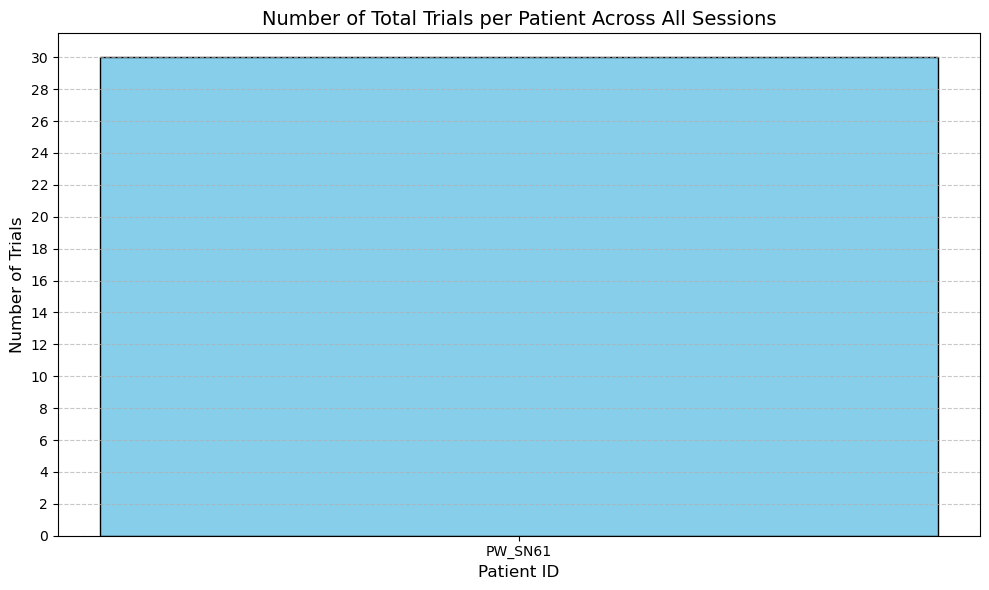

In [19]:
from tabulate import tabulate
import matplotlib.pyplot as plt

# Initialize variables
n_subjects = len(subject_event_idx_dict)
n_trials_list = []
subjects_list = []

# Collect data and display summary
print(f"Number of subjects: {n_subjects} with (n_trials x n_events)")
table_data = []
for subject_name, event_data in subject_event_idx_dict.items():
    n_trials, n_events = event_data.shape
    n_trials_list.append(n_trials)
    subjects_list.append(subject_name)
    table_data.append([subject_name, (n_trials, n_events)])

# Display data as a formatted table
print(tabulate(table_data, headers=["Subject Name", "Shape (Trials x Events)"], tablefmt="grid"))

# Plot histogram for the number of trials per subject
plt.figure(figsize=(10, 6))
plt.bar(subjects_list, n_trials_list, color='skyblue', edgecolor='black')

# Add labels, title, and grid
plt.xlabel('Patient ID', fontsize=12)
plt.ylabel('Number of Trials', fontsize=12)
plt.title('Number of Total Trials per Patient Across All Sessions', fontsize=14)
plt.yticks(range(0, max(n_trials_list) + 1, 2))  # Ensure y-axis has integer ticks
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

save_path ='results/figures/processed_data'
os.makedirs(save_path, exist_ok=True)
fig_name = 'trials_count'
plt.savefig(os.path.join(save_path, fig_name + '.png'))
plt.show()

In [20]:
min_trial_length = min(
    trial.shape[1]
    for subject_trials in subject_lfp_data_dict.values()
    for trial in subject_trials
)

max_trial_length = max(
    trial.shape[1]
    for subject_trials in subject_lfp_data_dict.values()
    for trial in subject_trials
)

print(f"Minimum trial length: {min_trial_length}")
print(f"Maximum trial length: {max_trial_length}")

Minimum trial length: 1155
Maximum trial length: 2035


In [22]:
print(f"{'-' * 25}\n| Number of subjects: {len(subject_lfp_data_dict)} |\n{'-' * 25}")
for i, subject_name in enumerate(subject_lfp_data_dict):
    print(f"\n{i+1}. Subject {subject_name}: Number of trials: {len(subject_lfp_data_dict[subject_name])}, each with shape (n_channels, n_samples):")
    print("=" * 82)
    for trial_idx in range(len(subject_lfp_data_dict[subject_name])):
        print(f"{trial_idx+1}. Trial: {subject_lfp_data_dict[subject_name][trial_idx].shape}")

-------------------------
| Number of subjects: 1 |
-------------------------

1. Subject PW_SN61: Number of trials: 30, each with shape (n_channels, n_samples):
1. Trial: (15, 1943)
2. Trial: (15, 1905)
3. Trial: (15, 1531)
4. Trial: (15, 1877)
5. Trial: (15, 1490)
6. Trial: (15, 1421)
7. Trial: (15, 1155)
8. Trial: (15, 1332)
9. Trial: (15, 1462)
10. Trial: (15, 1406)
11. Trial: (15, 1173)
12. Trial: (15, 1418)
13. Trial: (15, 1503)
14. Trial: (15, 1346)
15. Trial: (15, 1431)
16. Trial: (15, 1241)
17. Trial: (15, 1378)
18. Trial: (15, 1234)
19. Trial: (15, 1262)
20. Trial: (15, 2035)
21. Trial: (15, 1334)
22. Trial: (15, 1408)
23. Trial: (15, 1265)
24. Trial: (15, 1497)
25. Trial: (15, 1480)
26. Trial: (15, 1438)
27. Trial: (15, 1436)
28. Trial: (15, 1815)
29. Trial: (15, 1278)
30. Trial: (15, 1331)


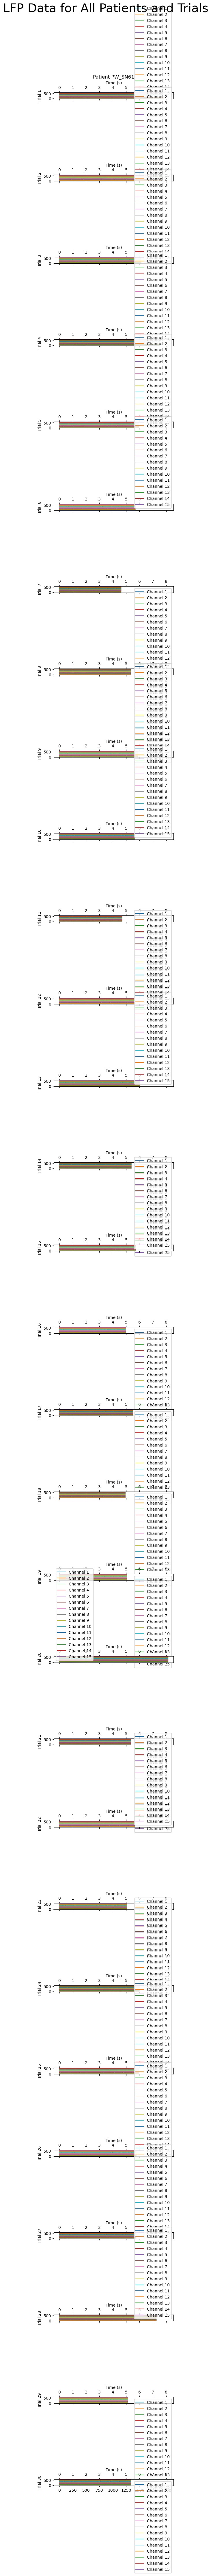

In [30]:
def plot_all_patients_trials(sharex=True, sharey=True, fig_name=''):
    num_patients = len(subject_lfp_data_dict)
    max_trials = max(len(trials) for trials in subject_lfp_data_dict.values())
    fig, axes = plt.subplots(max_trials, num_patients, figsize=(num_patients * 5, max_trials * 3), sharex=sharex, sharey=sharey)
    
    # Ensure axes is a 2D array even if there's only one patient or one trial
    if num_patients == 1:
        axes = np.expand_dims(axes, axis=1)
    if max_trials == 1:
        axes = np.expand_dims(axes, axis=0)
        
    for col_idx, (patient_name, trials) in enumerate(subject_lfp_data_dict.items()):
        for row_idx, data in enumerate(trials):
            ax = axes[row_idx, col_idx]  # Select the correct subplot
            num_channels = data.shape[0]
            for channel_idx in range(num_channels):
                ax.plot(data[channel_idx, :] + channel_idx * 40, label=f'Channel {channel_idx + 1}')  # Offset each channel for clarity
            if row_idx == 0:
                ax.set_title(f"Patient {patient_name}")
            ax.legend()
    
    for i in range(max_trials):
        axes[i, 0].set_ylabel(f"Trial {i + 1}")
    
    # Add secondary x-axis for time
    for ax in axes.flat:
        secax = ax.secondary_xaxis('top', functions=(lambda x: x / lfp_sfreq, lambda x: x * lfp_sfreq))
        secax.set_xlabel('Time (s)')
    
    # Adjust layout
    fig.suptitle("LFP Data for All Patients and Trials", fontsize=30)
    plt.subplots_adjust(hspace=1)  # Increase the vertical space between rows
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust to make room for the title
    plt.savefig(fig_name + '.png')
    plt.show()

save_path ='results/figures/processed_data'
fig_name = 'lfp_data_all_patients_trials'
os.makedirs(save_path, exist_ok=True)

plot_all_patients_trials(sharex=True, sharey=True, fig_name=os.path.join(save_path, fig_name))


In [32]:
fs = 128

In [33]:
print(f"Minimum trial length: {min_trial_length/fs} seconds")
print(f"Maximum trial length: {max_trial_length/fs} seconds")

Minimum trial length: 9.0234375 seconds
Maximum trial length: 15.8984375 seconds


In [35]:
int(max_trial_length/fs + 1)

16

In [36]:
subject_lfp_data_dict, subject_event_idx_dict

({'PW_SN61': [array([[ 9.17835961,  9.17857555,  9.23040055, ...,  9.59185969,
            9.51854348,  9.42404065],
          [-2.26136672, -2.25076675, -2.26297319, ..., -2.76186053,
           -2.70681244, -2.5938856 ],
          [ 2.97999561,  2.92356607,  2.8655332 , ...,  2.46905477,
            2.52394031,  2.55748845],
          ...,
          [ 7.30510895,  7.3122344 ,  7.32747503, ...,  8.05976442,
            7.96140041,  7.81706992],
          [-1.89314131, -1.97958049, -2.09656522, ..., -1.3930832 ,
           -1.35646237, -1.31266776],
          [ 6.21671857,  5.97562012,  5.75082309, ...,  6.29038494,
            6.48498738,  6.59772966]]),
   array([[ 9.0744788 ,  9.09889108,  9.12330475, ...,  9.1499905 ,
            9.05511792,  9.00906372],
          [-2.3281625 , -2.37479939, -2.40267095, ..., -1.70973176,
           -1.72401877, -1.77284254],
          [ 2.512536  ,  2.49814229,  2.47810292, ...,  2.43066394,
            2.45230069,  2.4271966 ],
          ...,
   

In [20]:
subject_lfp_data_dict[subject_name][trial_idx].shape

(15, 1331)

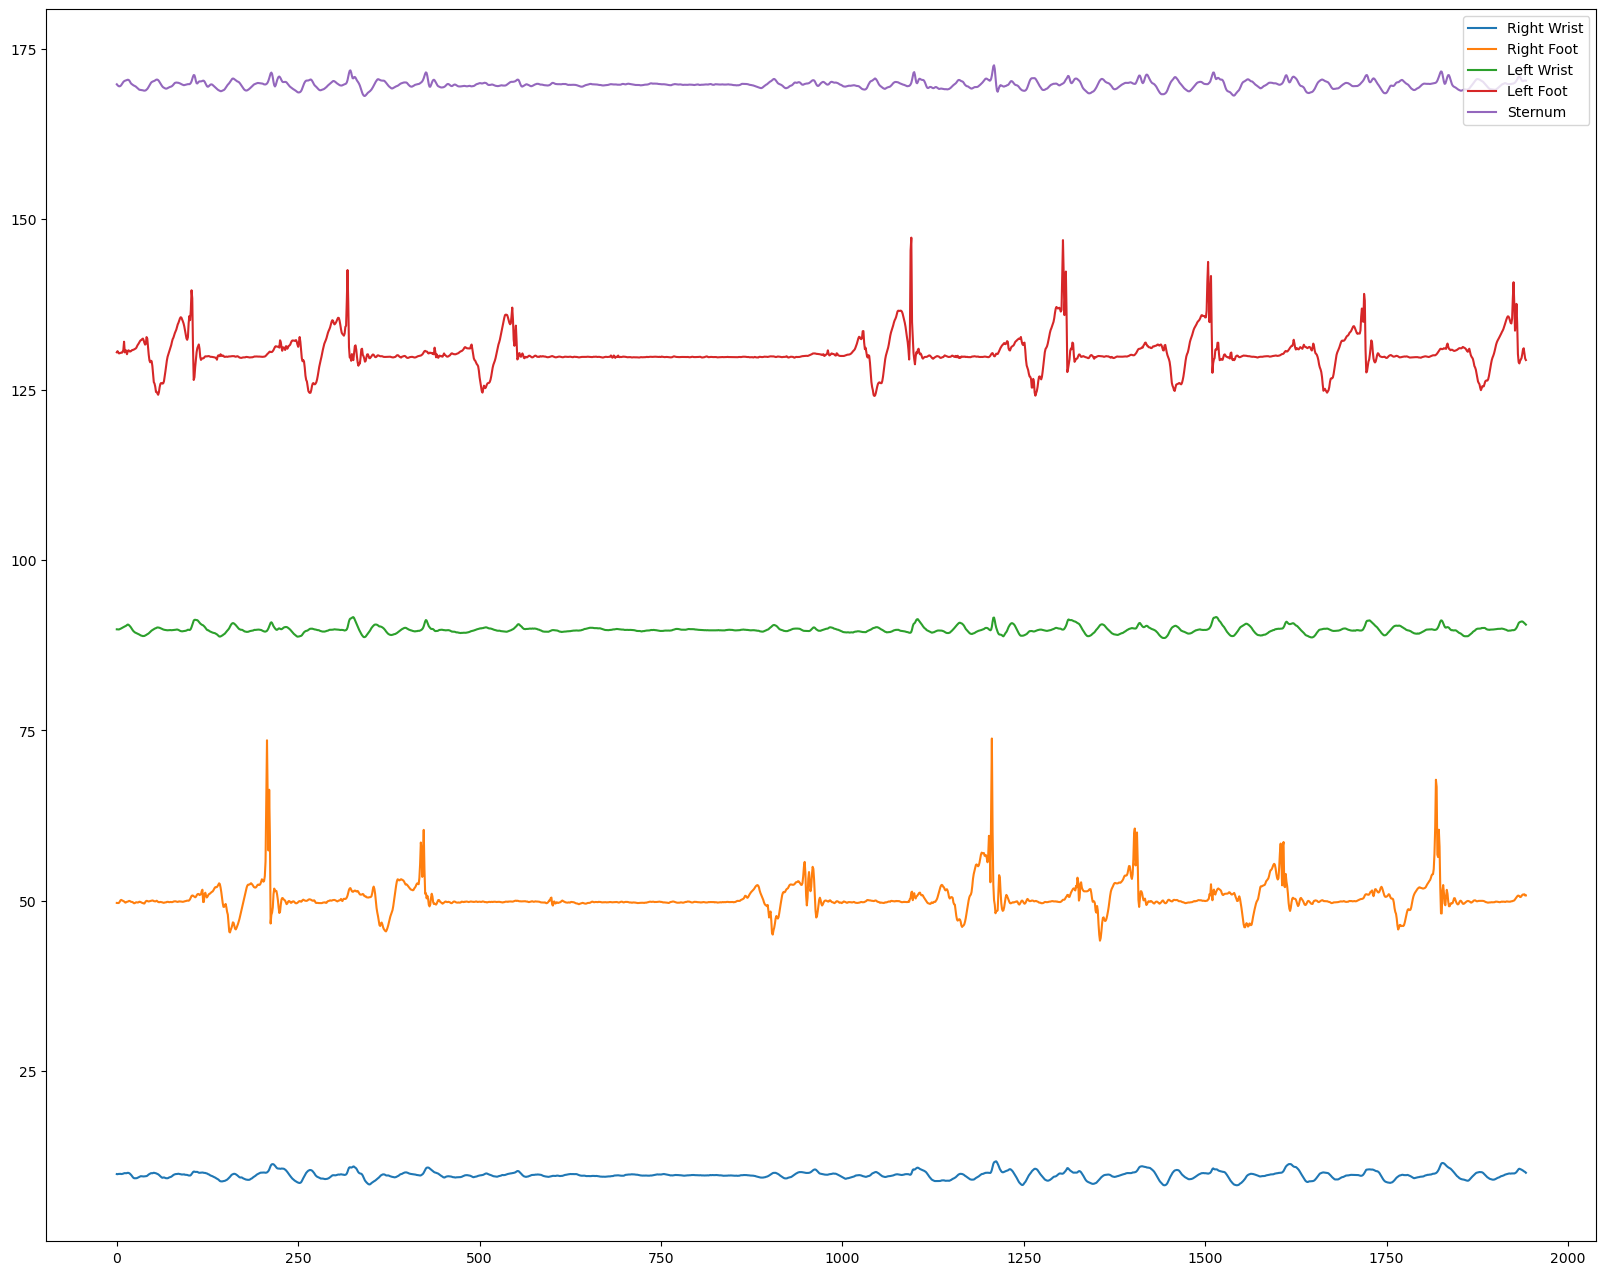

In [38]:
from scipy.integrate import cumtrapz
import matplotlib.pyplot as plt
import numpy as np

# Extract metadata
imu_metadata = DataProcessor.np_to_dict(first_data['hdr_IMU'])
imu_Fs = imu_metadata.get('Fs', None)
if imu_Fs is None:
    raise ValueError("Sampling frequency not found in IMU metadata.")
fs = imu_Fs.item()  # Sampling frequency

imu_labels = [subarr[0] for subarr in imu_metadata.get('label', np.array([])).flatten()]
if not imu_labels:
    raise ValueError("IMU labels not found or invalid.")

trial_idx = 0
subject_name = 'PW_SN61'
trial = subject_lfp_data_dict[subject_name][trial_idx]

plt.figure(figsize=(20, 16))

# Iterate over each sensor's accelerometer data
for sensor_idx, label in enumerate(imu_labels):
    vel_x = trial[sensor_idx * 3, :]
    vel_y = trial[sensor_idx * 3 + 1, :]
    vel_z = trial[sensor_idx * 3 + 2, :]
    
    # Resultant velocity
    # velocity_resultant = np.sqrt(velocity_x**2 + velocity_y**2 + velocity_z**2)
    velocity_resultant_speed = np.sqrt(vel_x**2 + vel_y**2 + vel_z**2)
    
    # Plot the velocity
    # ax.plot(velocity_resultant, label=f"{label}")
    plt.plot(velocity_resultant_speed + sensor_idx * 40, label=f"{label}")
    plt.legend()
     

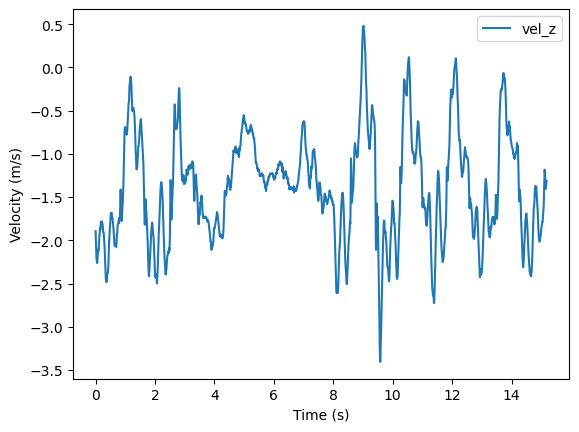

In [59]:
time_axis = np.arange(trial.shape[1]) / fs

plt.plot(time_axis, trial[13, :], label='velocity_z')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.show()

/var/folders/jk/skjgj9ps5xs02bklf7l0nsjr0000gn/T/ipykernel_71521/2343474898.py:5: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  vindal_x_vel = cumtrapz(x_vel_acc, dx=1/fs, initial=v0_x)


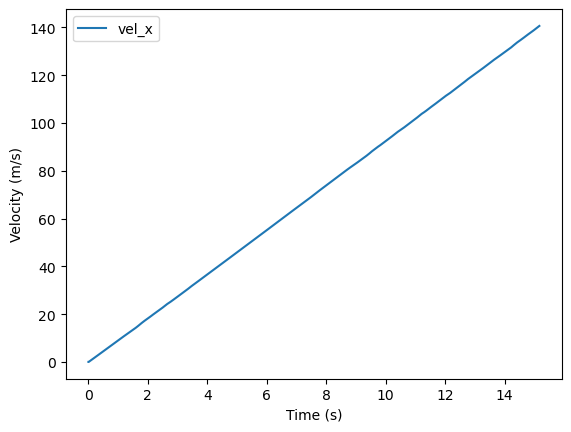

In [60]:
x_vel_acc = trial[0, :]
v0_x = x_vel_acc[0] * (1 / fs)

# Compute velocity by integrating acceleration
vindal_x_vel = cumtrapz(x_vel_acc, dx=1/fs, initial=v0_x)

time_axis = np.arange(vindal_x_vel.shape[0]) / fs

plt.plot(time_axis, vindal_x_vel, label='vel_x')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.show()

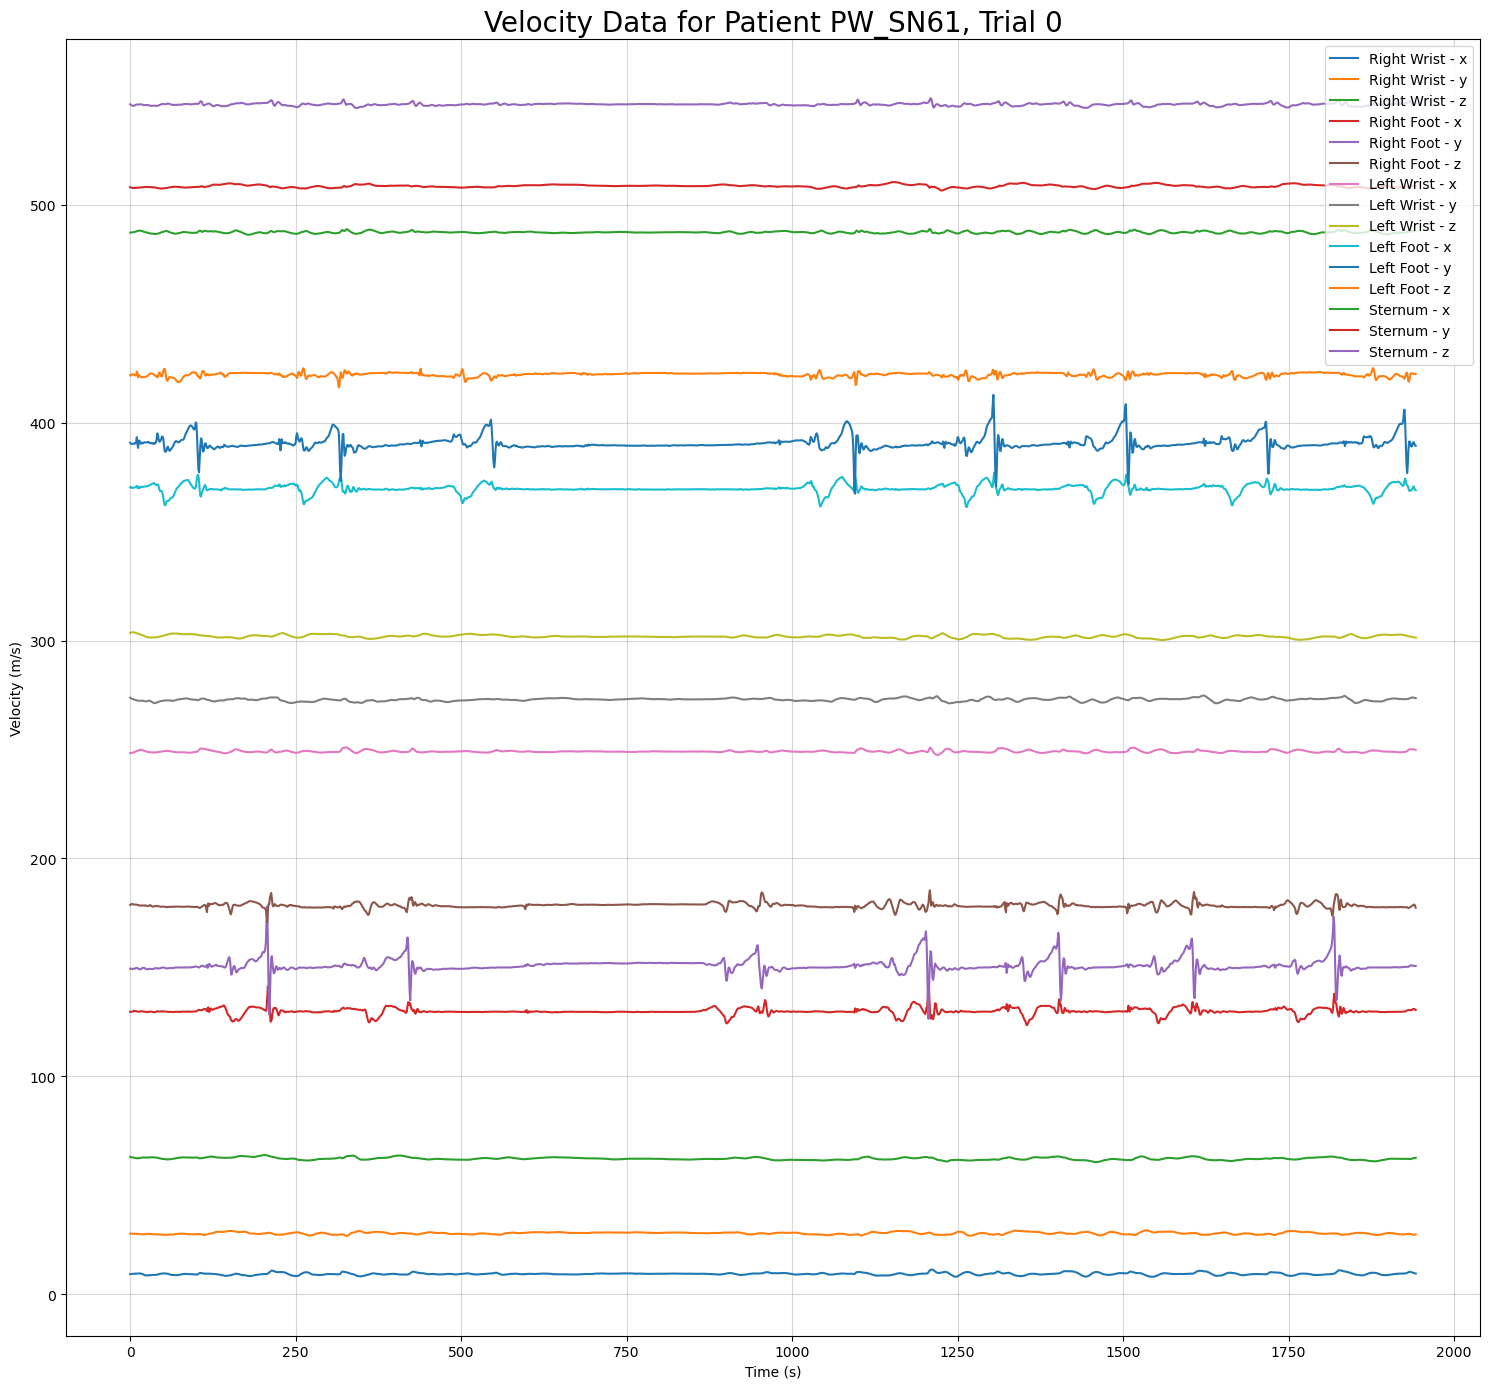

In [62]:
# Extract metadata
imu_metadata = DataProcessor.np_to_dict(first_data['hdr_IMU'])
imu_Fs = imu_metadata.get('Fs', None)
if imu_Fs is None:
    raise ValueError("Sampling frequency not found in IMU metadata.")
fs = imu_Fs.item()  # Sampling frequency

imu_labels = [subarr[0] for subarr in imu_metadata.get('label', np.array([])).flatten()]
if not imu_labels:
    raise ValueError("IMU labels not found or invalid.")

trial_idx = 0
subject_name = 'PW_SN61'
trial = subject_lfp_data_dict[subject_name][trial_idx]

plt.figure(figsize=(15, 14))

# Iterate over each sensor's accelerometer data
for sensor_idx, label in enumerate(imu_labels):
    vel_x = trial[sensor_idx * 3, :]
    vel_y = trial[sensor_idx * 3 + 1, :]
    vel_z = trial[sensor_idx * 3 + 2, :]
    
    # Plot the velocity
    plt.plot(vel_x + 0  + sensor_idx * 120, label=f"{label} - x")
    plt.plot(vel_y + 30 + sensor_idx * 120, label=f"{label} - y")
    plt.plot(vel_z + 60 + sensor_idx * 120, label=f"{label} - z")
    plt.legend()

plt.ylabel('Velocity (m/s)')
plt.xlabel('Time (s)')
plt.grid(alpha=0.5)
plt.title(f"Velocity Data for Patient {subject_name}, Trial {trial_idx}", fontsize=20)
plt.tight_layout()
plt.show()

/var/folders/jk/skjgj9ps5xs02bklf7l0nsjr0000gn/T/ipykernel_71521/555474613.py:47: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  velocity_x = cumtrapz(acc_x, dx=1/fs, initial=v0_x)
/var/folders/jk/skjgj9ps5xs02bklf7l0nsjr0000gn/T/ipykernel_71521/555474613.py:48: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  velocity_y = cumtrapz(acc_y, dx=1/fs, initial=v0_y)
/var/folders/jk/skjgj9ps5xs02bklf7l0nsjr0000gn/T/ipykernel_71521/555474613.py:49: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  velocity_z = cumtrapz(acc_z, dx=1/fs, initial=v0_z)


IndexError: index 1 is out of bounds for axis 0 with size 1

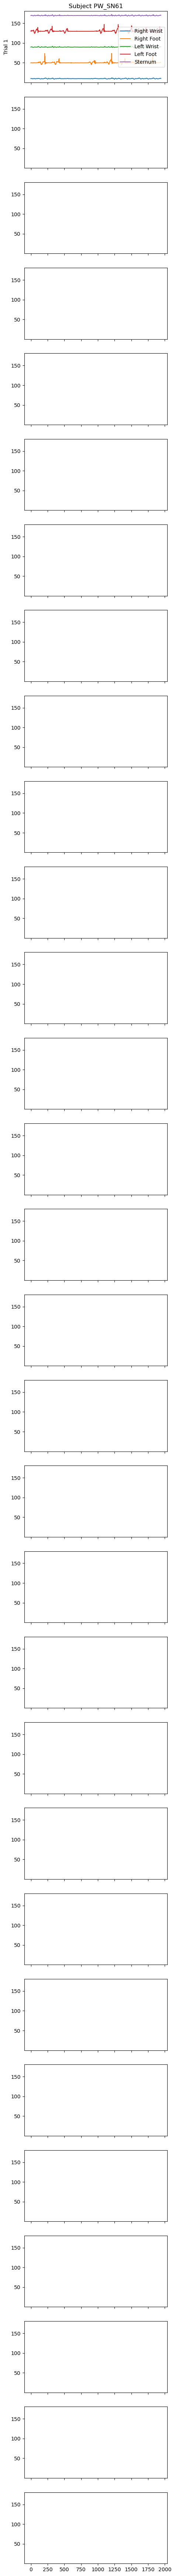

In [63]:
from scipy.integrate import cumtrapz
import matplotlib.pyplot as plt
import numpy as np

# Extract metadata
imu_metadata = DataProcessor.np_to_dict(first_data['hdr_IMU'])
imu_Fs = imu_metadata.get('Fs', None)
if imu_Fs is None:
    raise ValueError("Sampling frequency not found in IMU metadata.")
fs = imu_Fs.item()  # Sampling frequency

imu_labels = [subarr[0] for subarr in imu_metadata.get('label', np.array([])).flatten()]
if not imu_labels:
    raise ValueError("IMU labels not found or invalid.")

# Define the number of subjects and the maximum number of trials
num_subjects = len(subject_lfp_data_dict)
max_trials = max(len(trials) for trials in subject_lfp_data_dict.values())

# Create a figure with subplots
fig, axes = plt.subplots(max(1, max_trials), max(1, num_subjects),
                         figsize=(num_subjects * 5, max_trials * 3),
                         sharex=True, sharey=True)

# Handle case for single row or column
if num_subjects == 1 or max_trials == 1:
    axes = np.atleast_2d(axes)

# Iterate over each subject and trial to plot the velocity
for col_idx, (subject, trials) in enumerate(subject_lfp_data_dict.items()):
    for row_idx, trial in enumerate(trials):
        ax = axes[row_idx, col_idx]  # Select the correct subplot
        trial_length = trial.shape[1]
        
        # Iterate over each sensor's accelerometer data
        for sensor_idx, label in enumerate(imu_labels):
            acc_x = trial[sensor_idx * 3, :trial_length]
            acc_y = trial[sensor_idx * 3 + 1, :trial_length]
            acc_z = trial[sensor_idx * 3 + 2, :trial_length]
            
            # Estimate initial velocities
            v0_x = acc_x[0] * (1 / fs)
            v0_y = acc_y[0] * (1 / fs)
            v0_z = acc_z[0] * (1 / fs)
            
            # Compute velocity by integrating acceleration
            velocity_x = cumtrapz(acc_x, dx=1/fs, initial=v0_x)
            velocity_y = cumtrapz(acc_y, dx=1/fs, initial=v0_y)
            velocity_z = cumtrapz(acc_z, dx=1/fs, initial=v0_z)
            
            # Resultant velocity
            velocity_resultant = np.sqrt(velocity_x**2 + velocity_y**2 + velocity_z**2)
            velocity_resultant_speed = np.sqrt(acc_x**2 + acc_y**2 + acc_z**2)
            
            # Plot the velocity
            # ax.plot(velocity_resultant, label=f"{label}")
            ax.plot(velocity_resultant_speed + sensor_idx * 40, label=f"{label}")

        # Add titles and labels
        if row_idx == 0:
            ax.set_title(f"Subject {subject}")
        if col_idx == 0:
            ax.set_ylabel(f"Trial {row_idx + 1}")
        ax.legend()

# Add secondary x-axis for time
for ax in axes.flat:
    secax = ax.secondary_xaxis('top', functions=(lambda x: x / fs, lambda x: x * fs))
    secax.set_xlabel('Time (s)')

# Adjust layout
fig.suptitle("Velocity for Each Subject and Trial", fontsize=30)
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.show()
save_path = 'results/figures/processed_data'
os.makedirs(save_path, exist_ok=True)
fig_name = 'velocity_each_subject_trial'
plt.savefig(os.path.join(save_path, fig_name + '.png'))
plt.show()

In [31]:
acc_x = np.array([8.80782377132453, 8.77749024675531, 8.74642217746697, 8.75011907587524, 8.68021369493136, 8.59734505515677, 8.55185104286138, 8.47566003090255, 8.42271929410971, 8.45382276409766, 8.43236173471588, 8.42901183432087, 8.45342685049519, 8.45422693295047, 8.42822286142004, 8.60946315993911, 9.00819178187830, 9.60911557409498, 10.5837699534401, 11.6370721037281, 12.1977533082658, 12.1436626845241, 11.7079637628289, 11.2429012657051, 10.9449411750099, 10.8435309093180, 10.8334589869940, 10.9066937071984, 11.0211834184311, 11.2476344977778, 11.3684644302394, 11.3171250640705, 11.1900324315523, 10.9438384664529, 10.6054227971304, 10.2304133272635, 9.80404170329792, 9.28591051581390, 8.74750372726634, 8.34672591750950, 8.03521808332294, 7.75402122933566, 7.53044458426145, 7.40109464521599, 7.38500230821653, 7.43676054344915, 7.51833072771233, 7.67653160368670, 7.88356852998322, 8.14526299320750, 8.48896707231831, 8.91325796474510, 9.31952894692292, 9.65404974689530, 9.82887219283987, 9.92996327009069, 10.0002803056688, 10.0379217459615, 9.98668710527013, 9.88320204390864, 9.75528065213042, 9.60298216361238, 9.44667723235928, 9.33682106570348, 9.23570704606638, 9.16538333331407, 9.10727413128177, 9.05844809190669, 9.01544374573832, 8.98229875199515, 8.91543274799749, 8.82998899710343, 8.74163175453028, 8.64108010825481, 8.54284494955094, 8.47891161948797, 8.40275663935317, 8.32603630052734, 8.26849214773085, 8.20337486267090, 8.19466470341407, 8.16675281524658, 8.15804845814087, 8.13593136562303, 8.15744596960846, 8.17545248503022, 8.22656155804368, 8.32131407557545, 8.40966321576026, 8.51021961352792, 8.61718645624356, 8.70614560729926, 8.76717075005105, 8.82531373424230, 8.86835642319976, 8.89855180518447, 8.94159812067816, 8.95734481074266, 8.95957636909480, 8.99974318115953, 9.02638584602694, 9.08519296984318, 9.10894316884908, 9.21322176304139, 9.52659235764624, 10.1039548542825, 10.8465361693414, 11.6606512072144, 12.2664964594854, 12.5254898305679, 12.4104668344927, 12.0665152910362, 11.6902722422542, 11.3894576254833, 11.2020620605818, 11.0368942115713, 10.6886181623243, 10.2118588602366, 9.76667597667927, 9.31434900478919, 8.90215164516050, 8.51658086712024, 8.23572903689992, 8.13947199066053, 8.16165152100188, 8.32742734805047, 8.60743829374901, 8.92479954605767, 9.21928316326525, 9.41324411315059, 9.48591676485244, 9.40562999497271, 9.21106310804995, 8.97342600800475, 8.72565547772716, 8.50880821642552, 8.31558569650801, 8.18338172279826, 8.10079311555432, 8.03611385437750, 8.01662037806826, 8.05323883379904, 8.10139545506995, 8.17846027179919, 8.24192091037228, 8.34300057020056, 8.41331760577870, 8.45973014831543, 8.45973014831543, 8.45680808630346, 8.44460105505346, 8.42655056526578, 8.38993247974610, 8.35039506200272, 8.30740460418150, 8.27715698975633, 8.22541145025410, 8.17021106394713, 8.13067106118067, 8.08185126899879, 8.03593571333780, 8.00805664062500, 8.01679492741442, 8.05050354279767, 8.09238039612633, 8.19584933660364, 8.32955672221255, 8.50044349200654, 8.66261910702559, 8.77944810049874, 8.84338936805115, 8.91953141946885, 9.00498089655465, 9.08461779200353, 9.13984689232819, 9.17066127213659, 9.20026890558886, 9.24221981140863, 9.15906491286316, 9.15431501019386, 9.21431305825626, 9.21408921757907, 9.43545855948520, 9.78403928151373, 10.4779287904871, 11.7575418898776, 12.5578867815741, 12.5771588296320, 12.4624588682977, 12.0587469165409, 11.5858371217496, 11.3124396055498, 11.1357767761395, 10.9664509814878, 10.8925544089724, 10.8357578664331, 10.6589159206897, 10.2616970407537, 9.70147346543942, 9.07829450172513, 8.52984854599189, 8.14292857028006, 7.92399537601469, 7.86086778956929, 7.92983524560074, 8.06411271819717, 8.20987640299322, 8.41021185170304, 8.67517939862591, 8.97100033884590, 9.23597144348191, 9.35301786829790, 9.39682884108907, 9.36166852873642, 9.23744311308901, 9.05508706756733, 8.83538195340166, 8.60993105781290, 8.37723469279509, 8.19913823445313, 8.08567886311038, 8.01740255126328, 8.01663912735659, 8.04753861215474, 8.06546733115133, 8.11065713942997, 8.18961452189716, 8.30154666861570, 8.44881688883167, 8.54154362160373, 8.56388801163112, 8.53091524420063, 8.47273317195688, 8.42390719975267, 8.38078067599888, 8.35922085488081, 8.34416414817713, 8.31975079828120, 8.31528350703621, 8.37346450317902, 8.40805379000311, 8.39299969909348, 8.37996928304010, 8.39869308471680, 8.40153687488220, 8.41374343905276, 8.43163324860865, 8.47676846007656, 8.55569650011963, 8.65901564379658, 8.77541724037325, 8.89291610725099, 9.08738933835676, 9.29377745263756, 9.40450091491402, 9.46640583703815, 9.53897400798283, 9.85019175402869, 10.4607823140975, 11.1591228060520, 11.6884691430530, 11.9340754467338, 11.7815974897235, 11.3468021491449, 10.8435362878475, 10.3224001677904, 9.80980684179572, 9.46156420697936, 9.29921779696041, 9.30958907322217, 9.40615965699330, 9.52058834199975, 9.54737182965310, 9.50405802312343, 9.48515224456787, 9.47964784775786, 9.44697381579299, 9.37769529532874, 9.26627653323082, 9.12135532765406, 9.05393076766915, 9.07956041305048, 9.05635904682960, 8.97335555802749, 8.79820823095740, 8.57452222694206, 8.39018413624751, 8.24370974439630, 8.11642027932673, 8.05813007432866, 8.01752287146377, 8.01079709023623, 8.01204679626578, 7.97816616708782, 7.94827746508843, 7.92134230068508, 7.98111091778045, 8.07601727172160, 8.16146935149455, 8.23872204200463, 8.28754853604241, 8.32817885207935, 8.32946622121413, 8.30103397369385, 8.30649251391096, 8.31726856580833, 8.26974158736849, 8.17611877794013, 8.06221792934067, 7.97950692971547, 7.89809444730938, 7.79912552786551, 7.73263994342139, 7.65264641707577, 7.60521221160889, 7.61336919605824, 7.64999030564974, 7.68389161226387, 7.71102372530602, 7.75579843994781, 7.83175523976154, 7.91447377842672, 7.99584579571527, 8.11383929183642, 8.25762249863847, 8.39458667664301, 8.54649006150130, 8.71196027407570, 8.87739915565814, 9.08766451189595, 9.20300081578268, 9.28972108804807, 9.60955705635377, 10.3430085086969, 11.3032958728499, 12.2028843417756, 12.6752957787508, 12.6161583981379, 12.0399874058737, 11.3263485089591, 10.8026565392832, 10.4390296227982, 10.1758683053415, 9.96139268187734, 9.86230743453116, 9.77972605139601, 9.59407422205112, 9.33489944308584, 9.17602425644335, 9.12430854229456, 9.17023462353878, 9.31379857236644, 9.56039973829859, 9.88068347702378, 10.1275106208144, 10.3006168429936, 10.1919658693117, 10.1013979518713, 9.88193514794378, 9.56072183541622, 9.17692936986639, 8.76873410997692, 8.34420961072163, 7.94259077429588, 7.59394233095254, 7.27508265814657, 7.01840848909303, 6.88497543334961, 6.90638445013772, 7.01739250069329, 7.17341096017023, 7.29583723544159, 7.32978865146088, 7.34885692596436, 7.35419663005025, 7.37860639011073, 7.41368899906275, 7.47892827555514, 7.52354839491466, 7.58879424374311, 7.63074130103702, 7.69177665958236, 7.75813067415590, 7.84357382820254, 7.93966680041169, 8.07127837624414, 8.18803957655108, 8.27770836582474, 8.34405310962930, 8.44012626095597, 8.58238570587025, 8.74794550620771, 8.89708434319383, 9.04249773230604, 9.12158336507560, 9.12317877500566, 9.08390845729947, 9.11728481665307, 9.53698443585455, 10.3530332804245, 11.2870998840303, 11.7275826722246, 12.1177031448552, 12.0402937234516, 11.5069557512877, 10.7794883778568, 9.96366437019841, 9.28845535958051, 8.82872583520377, 8.61842632293701, 8.67665570734039, 8.97164749159181, 9.33582104810234, 9.59906934483260, 9.84849799263726, 10.1064637434892, 10.3103383706441, 10.4013544960139, 10.2677264665804, 10.0242704852632, 9.68416280635383, 9.30577136966063, 8.91153718591209, 8.46781210086313, 8.06594354938823, 7.74356711733193, 7.55448266584569, 7.43504005984899, 7.33570110680397, 7.27992998674718, 7.25119733810425, 7.26171092161813, 7.30528338672897, 7.34020280648792, 7.41081886390375, 7.48235077499062, 7.58696450092233, 7.66453515297775, 7.70287132263184, 7.68976069888395, 7.62610360612702, 7.54500814444214, 7.44301354991892, 7.36716557135122, 7.29217600373869, 7.24771169186188, 7.17447486188677, 7.10384462213004, 7.04542322889968, 7.00704956054688, 7.04101090752848, 7.20491352828417, 7.38540415578344, 7.54584111589929, 7.66791486813359, 7.77694702172850, 7.86664934055780, 8.18968605885308, 9.16557731931133, 10.9254226032673, 13.0904676065576, 14.9974512318984, 15.7549108978607, 15.2092337809130, 13.9384990171731, 12.5853048155363, 11.8237287512086, 11.2282234131832, 10.9201401122535, 11.5987611470600, 12.0717468530291, 12.3162011148010, 12.4001278210187, 12.3697749389115, 12.2280526974740, 11.8892168578770, 11.4020488080937, 10.8128727358719, 10.1813663431156, 9.59732550959433, 8.98252693944287, 8.40180293773909, 7.85062132744696, 7.34830047262673, 6.90769983588932, 6.56408275071011, 6.28987971893822, 6.13635936939466, 6.01756075608141, 5.97715081658293, 6.01377187458147, 6.07356751154340, 6.24065847636124, 6.48223108910806, 6.71416557282229, 6.96409860953757, 7.29176600765993, 7.65535325830655, 7.99910673789387, 8.29397873468297, 8.53747672233938, 8.71222328883346, 8.80474239748754, 8.87284307127098, 8.91910217776399, 8.94033007424634, 8.88832872276741, 8.78103560102456, 8.68081972938930, 8.56073299606239, 8.41482909668977, 8.31973884951684, 8.22917119437169, 8.12187338986277, 8.02933229564568, 7.96376467581230, 7.93225588268161, 7.93537921509985, 7.99641464364738, 8.06510559375995, 8.14999688335376, 8.18916714844555, 8.24565027130256, 8.37189750554192, 8.72405792188968, 9.37458771913500, 10.1238248195235, 10.8214318744964, 11.3806835213127, 11.6881402742539, 11.6970456995000, 11.3652849292621, 10.8199321238135, 10.2076753373642, 9.64413633106095, 9.13710080472494, 8.74603498557245, 8.53088665850992, 8.33510963502429, 8.34325697577067, 8.36002773569074, 8.17692391531459, 8.22829935475631, 8.31219117505942, 8.49833395306255, 8.75516210782392, 9.07306299119280, 9.42652166017922, 9.71394274653500, 9.90068375809495, 9.94142523961866, 9.88198139669647, 9.72537914273194, 9.53516336959628, 9.36173285593316, 9.17358110418579, 8.96859012522222, 8.78340118500018, 8.64196030870528, 8.52242996670381, 8.41510408983239, 8.31745155006285, 8.22736451129335, 8.17391016967590, 8.16211580915853, 8.18864559797647, 8.17895984649658, 8.18148051721892, 8.19872848193868, 8.23030911253808, 8.23495725270943, 8.21306530231704, 8.18575508787067, 8.09528011916786, 7.98541677671008, 7.87052913927541, 7.75133067313770, 7.69281542159280, 7.65906664181744, 7.68598930987997, 7.72260763360730, 7.76926821558767, 7.85722469227803, 7.96489372572083, 8.09885264077637, 8.18929991882660, 8.30668916304398, 8.44313753321204, 8.54831798955785, 8.68258271912492, 8.80934228803107, 8.91949265026399, 9.06818510941960, 9.19303280124283, 9.43361273082903, 9.98744646305313, 10.9682197142361, 12.3222399258391, 13.8654989534039, 14.8474837169852, 14.8358225936577, 13.9681337558266, 12.9932875857224, 12.3610924278222, 11.7510881138287, 11.2194299769893, 10.8268182901724, 10.5291227564345, 10.2481379654837, 9.92601758724687, 9.63054000248163, 9.33037573377663, 9.05206833278784, 8.79595328604047, 8.61326608788444, 8.54518222808838, 8.55510073075538, 8.59896946221975, 8.62586434478799, 8.66991003708417, 8.73819922839391, 8.77959784934048, 8.76705613460367, 8.64977946381537, 8.49092809769159, 8.28342307340287, 8.07590243850859, 7.88816261859167, 7.78324146358626, 7.70520915993653, 7.64651246011662, 7.56119252679535, 7.52950217271300, 7.53208209475797, 7.60297348928653, 7.71036612944791, 7.81540993839773, 7.93737350214063, 8.00077328329230, 8.03994050760850, 8.12776003759099, 8.18150290629727, 8.24737475505181, 8.29382312000294, 8.37189704994635, 8.40844447052424, 8.39869308471680, 8.39623980270675, 8.38403308545675, 8.37673074162684, 8.38403433405676, 8.39144144116825, 8.46953489885997, 8.51835474880060, 8.57705935206082, 8.68003588374676, 8.80710280477108, 8.94858276935583, 9.07814404113977, 9.24930180724437, 9.48400846360222, 9.79444554403499, 10.1952694191390, 10.7159338280694, 11.3230648838958, 11.7073932492422, 11.7572385454001, 11.4730465005620, 10.9747929100617, 10.4376673225983, 9.92046756297636, 9.49348455664444, 9.13496432395319, 8.89400357820459, 8.81601400565808, 8.76221490528910, 8.67407065533847, 8.51023509880596, 8.28324252079410, 8.10303584796647, 8.04715789954071, 8.04945536277505, 8.03017094290324, 8.08643133177613, 8.18921640748391, 8.38732988383913, 8.69002464515094, 8.96811528743695, 9.16560516494132, 9.26309903544103, 9.29463039756081, 9.24813385898608, 9.15526777183976, 9.02828009274167, 8.86944256629485, 8.66442472191267, 8.47897361106975, 8.33496037452570, 8.20806556332055, 8.10795485456118, 8.00548923267348, 7.92978912949822, 7.84433282535339, 7.76873616027002, 7.73703328569069, 7.72728633880615, 7.72728633880615, 7.72728633880615])

In [117]:
for i in range(len(acc_x)):
    print(acc_x.round(4)[i])

8.1219
8.2322
8.3534
8.5583
8.7348
8.7392
8.5086
8.1524
7.8028
7.5839
7.5511
7.6335
7.8013
8.0402
8.28
8.4322
8.4841
8.4698
8.4045
8.3042
8.2235
8.155
8.0749
7.9555
7.8212
7.6965
7.5818
7.4646
7.3451
7.2061
7.0644
6.9301
6.8245
6.7873
6.8064
6.86
6.9306
7.0112
7.0797
7.136
7.1991
7.3132
7.4671
7.6136
7.7457
7.8223
7.8324
7.8249
7.863
7.975
8.1426
8.329
8.4157
8.3613
8.1693
7.9347
7.7577
7.6621
7.6032
7.5475
7.4573
7.3454
7.2112
7.0864
6.967
6.847
6.7731
6.7365
6.7046
6.6897
6.6897
6.6944
6.7066
6.7141
6.7283
6.7602
6.8036
6.8863
6.9887
7.1033
7.2253
7.3379
7.4261
7.4899
7.5434
7.5761
7.5591
7.5489
7.5469
7.5225
7.4886
7.4587
7.4493
7.4201
7.3835
7.3138
7.2248
7.2638
7.4508
7.7205
8.0454
8.3297
8.4719
8.3587
8.0516
7.7928
7.7595
8.0097
8.453
8.8941
9.1095
8.9531
8.5634
8.1832
7.9158
7.7412
7.6239
7.5093
7.3872
7.2558
7.0952
6.9309
6.8201
6.7704
6.8052
6.9151
7.0531
7.241
7.4316
7.5865
7.6822
7.7602
7.8315
7.9132
8.0334
8.1076
8.1348
8.1095
8.0428
8.0296
8.0634
8.1029
8.1085
8.0841
8.031

In [32]:
acc_y = np.array([
    -2.60869541373278, -2.71190180215041, -2.85876509921431, -2.93606563202172, -2.93531792971396, -3.01152038034023, -3.07922331224586, -3.09142920013642, -3.10658952119667, -3.11918757172739, -3.09181775953997, -3.06701011289649, -3.07036189772322, -3.01052500764590, -2.88980605758279, -2.91165634722693, -2.84290002845824, -2.65903395508963, -2.59053687822251, -2.68998168422031, -2.88606261819483, -2.94908802593542, -2.82996916575635, -2.68765259952006, -2.42873111177647, -2.13832702932148, -1.91483578740841, -1.76795326534344, -1.70819590240622, -1.82941037636199, -2.03061322523234, -2.20616472335089, -2.27222235724912, -2.32497436855002, -2.11188077926636, -2.07953085749197, -1.92760403569515, -1.64951194821835, -1.27250895353098, -1.28765293005120, -1.31500435385099, -1.33694265504569, -1.32133382170511, -1.35407165516906, -1.44879517138088, -1.53717322803432, -1.62604082150998, -1.67827734981386, -1.68510445882611, -1.63921064834932, -1.59673709367708, -1.53863283340222, -1.51029112678702, -1.55569158100249, -1.62600363234770, -1.70166706050047, -1.80618790481333, -1.86086015646664, -1.92533120461855, -1.96194739060005, -2.00149239857910, -2.06490767545353, -2.17185225484314, -2.28408918048685, -2.47487749707925, -2.75908721817525, -2.96584753024049, -2.99428177783377, -2.95474460053572, -2.87680719674374, -2.70880450159369, -2.54721255730923, -2.37049837844098, -2.17812052827351, -2.00954737192168, -1.90784163899923, -1.87994015216827, -1.87703516528476, -1.87354258948024, -1.89795671445558, -1.92527250641136, -1.96479661082025, -2.01652149755580, -2.07175200716752, -2.12287549244949, -2.21763194451087, -2.30597115734788, -2.39782650130136, -2.45368814468384, -2.45948243525720, -2.48389647139121, -2.51120225300653, -2.55360224453901, -2.61752939053356, -2.68209403878411, -2.71293398324802, -2.73958693076206, -2.80127319617658, -2.82568490543363, -2.84721161369599, -2.85075827471155, -2.82634753067413, -2.77884804302388, -2.65679414677354, -2.53471564953670, -2.43859914590686, -2.42927336692810, -2.42063347025523, -2.38689190594073, -2.37687145583274, -2.41349245423806, -2.42997331303080, -2.37826873959217, -2.35461621960798, -2.46664709805618, -2.61958033121127, -2.74811100657673, -2.86371115806832, -2.97214177004480, -2.98507496221257, -2.97787833671482, -3.01809636002969, -3.00735800663528, -2.91045933256867, -2.77618197062463, -2.63045635311285, -2.43589486496619, -2.19825149168434, -1.94476606292607, -1.70064188041750, -1.47366621800060, -1.30849420365016, -1.16485629215385, -1.05918447396356, -1.06127376661981, -1.12152804486748, -1.22774724989626, -1.35631232326961, -1.47758801233384, -1.61058966575130, -1.66798155281526, -1.76198518712644, -1.88423193340830, -2.01857513735615, -2.17191475267433, -2.25493802343096, -2.27985953491262, -2.26180472872715, -2.21640770423739, -2.13148885858529, -2.00357061749657, -1.83663375689220, -1.61640359878418, -1.45958167989011, -1.40385138988495, -1.40676884956685, -1.42189295130473, -1.44047355651855, -1.45214043682361, -1.51844660360204, -1.65217797761078, -1.79685072883302, -1.85496898174774, -1.89505993997976, -1.92764165025201, -2.03692997441924, -2.16304940690949, -2.22408033772365, -2.29383870344774, -2.40020806448800, -2.54029766753131, -2.67864368264637, -2.76640892861885, -2.90358059380644, -3.03264671215461, -3.09427600521506, -3.13318978171439, -3.16644077933919, -3.07854996013776, -3.18014097433486, -3.35413912913260, -3.40274031502250, -3.53107232448158, -3.29851830110952, -3.34059436535173, -3.94651778779078, -3.84049004149257, -3.62078056276234, -3.71169115040410, -3.61953106923892, -3.37314369085808, -3.10617562684851, -2.97217449321542, -3.01968778655149, -3.16771183661985, -3.39095796555418, -3.57473961568193, -3.68375387305930, -3.62830500726005, -3.43301154595857, -3.26363440092739, -3.18970449197860, -3.13293716359135, -3.01375201996082, -2.90963906263365, -2.81843687339704, -2.72295878941433, -2.67988124137284, -2.65834056508689, -2.63464586233031, -2.57073883340192, -2.49175738735856, -2.39409454014712, -2.32514533537510, -2.34669171044269, -2.35602879524231, -2.37323137927449, -2.45793595968448, -2.58575236777498, -2.74940907579876, -2.95764306414590, -3.11422394943189, -3.22408727264185, -3.31964635137803, -3.34559398689690, -3.28534163085241, -3.19340069037950, -3.10588092774656, -2.96302995349710, -2.79213138934548, -2.61268584346491, -2.41088719302059, -2.22492848226268, -2.04958872260334, -1.92260193330478, -1.74522740939795, -1.60078539145553, -1.50598189425124, -1.43762365541613, -1.43681121142561, -1.47627701596974, -1.52510511383851, -1.59384497149140, -1.71389320033426, -1.78997909229329, -1.86973754638168, -1.93361269748818, -1.99264646217469, -1.99349364369063, -1.96823003007911, -1.98895378505784, -2.02926553081663, -2.04998605214388, -2.11582439241467, -2.23221706129378, -2.31286779302008, -2.31461773229350, -2.24987402656383, -2.23024448107843, -2.26685951113762, -2.32045806304114, -2.42465963520538, -2.49596937072273, -2.51755302434204, -2.50149427060814, -2.39163845902642, -2.29872450623487, -2.27622435575745, -2.32604854912210, -2.46031691566590, -2.59442837330887, -2.72538913286781, -2.83644702940184, -2.90141842375335, -2.92977690696716, -2.91051167938746, -2.82780894898746, -2.73532255418382, -2.55461082584815, -2.29555747494353, -2.05448584231283, -1.93548213057444, -1.91381397667515, -1.91808882832878, -1.98186323134035, -2.05784451479309, -2.14878120725078, -2.25589445329482, -2.34806657154826, -2.41856278105998, -2.48782251354858, -2.57725738652092, -2.62459158897400, -2.62459158897400, -2.61637940068686, -2.57155233148545, -2.50104753437755, -2.43182355147170, -2.31776579715506, -2.15779443774172, -2.05212169859700, -2.01149151429603, -2.01293392890670, -2.06995333763983, -2.15812955797863, -2.26667670921613, -2.41043474636691, -2.53925542482843, -2.63004388014679, -2.65173027015501, -2.67483061638254, -2.72769589333173, -2.74121972722473, -2.70592754053813, -2.63268524340443, -2.58120004079675, -2.59202087079611, -2.55540241419323, -2.53236735999371, -2.55678213774944, -2.57576203346252, -2.57847602828492, -2.59881916504487, -2.66391452539137, -2.79141792928834, -2.93787747722251, -3.08436222044680, -3.22000422187176, -3.33119923202112, -3.50070579370595, -3.68387302776147, -3.74364123647175, -3.67581249357399, -3.66213659842199, -3.80985049846169, -4.08521391304102, -4.31993805411590, -4.45430067176628, -4.44371976500832, -4.18349412679825, -3.81038325308655, -3.57421262503525, -3.51147137950969, -3.66873326696548, -3.84788154512224, -3.95107432172387, -3.94996990170783, -3.79417573172681, -3.56224807894746, -3.34111092585633, -3.15800508411627, -2.97491222238516, -2.80255605712768, -2.65485709850689, -2.45954413901031, -2.26156052826492, -2.04866533500991, -1.85162489132215, -1.82132772029987, -1.95410337352899, -2.12232552988372, -2.28101724277122, -2.42629515918745, -2.54269334950083, -2.71776508967611, -2.86423935657639, -3.00537115868725, -3.11673395601037, -3.19265783876600, -3.26739779900601, -3.27461205388739, -3.15290769375694, -2.93467346672577, -2.65964843820064, -2.33658356244893, -2.08027934144536, -1.82659817510937, -1.59580385926071, -1.42069043483846, -1.29019893862047, -1.21163319264139, -1.11131272043780, -1.03074667305155, -1.05515903312307, -1.08755575836994, -1.14592835741699, -1.20806578411635, -1.32323690663375, -1.45750111658076, -1.59442967158886, -1.75686936403499, -1.96062895588489, -2.12038669265157, -2.33319856622435, -2.53860534867200, -2.65377502897310, -2.77743591944255, -2.83636961002199, -2.82095676530117, -2.86079336556427, -2.82415374546278, -2.82468244740124, -2.94569510457215, -3.05605748999259, -3.29488966896432, -3.46690249443054, -3.44836167631794, -3.36026117622211, -3.29703329589934, -3.38718260872749, -3.59043597183291, -3.79854321882655, -3.89945214261292, -3.88949248977521, -3.73142186527015, -3.48994074225487, -3.26329061357309, -3.04786287212274, -2.81428374982317, -2.60843440483310, -2.35640538661898, -2.09411657048810, -1.91198276448125, -1.78561870760632, -1.71693932021395, -1.80357855257054, -2.09316639770805, -2.44886255886881, -2.74519706852653, -2.95964837596164, -3.13392462932421, -3.22894558751516, -3.30651099825583, -3.34482860565186, -3.33432266893146, -3.27762207164559, -3.19742245144992, -3.13114669431908, -3.04045920157152, -2.94370315499753, -2.90536189079285, -2.92370346738971, -3.00914202573692, -3.11027630137628, -3.27421846231700, -3.45469046929849, -3.62296263035053, -3.75551574097739, -3.78429508209229, -3.77384405604888, -3.74069015787213, -3.74943552890681, -3.70321899757746, -3.67703649332996, -3.69967603720095, -3.75549598773432, -3.75301711313919, -3.60652820818618, -3.50956041456169, -3.65231217507271, -4.03496773496535, -4.47895731806328, -4.69724712398680, -4.60439583838070, -4.18002498512961, -3.64377470316220, -3.07749219732921, -2.46199503270895, -2.76950249976482, -3.27561823329684, -3.94466647110532, -4.35285515914620, -4.29472320174097, -4.09607594500306, -3.85528016203301, -3.68255095126625, -3.53273562741823, -3.30712953713895, -3.01413017916463, -2.72894535636023, -2.49070868445743, -2.34309787611075, -2.31567856427208, -2.42108188374984, -2.54502018534805, -2.62271028265731, -2.65863273959451, -2.64384669837620, -2.62717088201878, -2.63422226899719, -2.63232103340699, -2.65863865971016, -2.63870559383281, -2.57442440866997, -2.43432936603703, -2.23197176461945, -2.04887066814702, -1.87607520929358, -1.74435562529333, -1.63257609195607, -1.54648256600933, -1.41735262438632, -1.32033229396024, -1.28177738189697, -1.28177738189697, -1.29973615874375, -1.39799693058597, -1.55984736264088, -1.80262759243218, -2.12704983601236, -2.42457502327395, -2.68031260659618, -2.86991792748653, -2.98430533743002, -3.06719713819541, -3.14810360045660, -3.24774276805904, -3.29855376253113, -3.30565169601240, -3.29089208529414, -3.25626581554054, -3.18047707180335, -3.09247601784467, -2.98972613068037, -2.87785510224660, -2.80716832898940, -2.75122696757546, -2.73247064185399, -2.77618903777530, -2.78783989489780, -2.75121877746699, -2.72225093841553, -2.71714864355053, -2.70038481104758, -2.71514017823318, -2.74464689702543, -2.82913021093506, -3.05903055927021, -3.31742037621062, -3.53456513147994, -3.75226021157815, -3.97554076629051, -4.07320456545097, -4.16322132189702, -4.20139190309350, -4.15510564625088, -4.11340136414512, -4.02192378471402, -3.78902044860266, -3.42898036822396, -2.95547608049235, -2.53471662774520, -2.29613848979863, -2.14298990684720, -2.07778968030445, -2.07734630740244, -2.06140286815955, -2.17884727999246, -2.31775815380408, -2.42508269830228, -2.53536189760515, -2.67636727743426, -2.75467024511066, -2.82454279572836, -2.79801864625854, -2.80770277976990, -2.81022454263245, -2.81738952640015, -2.81526347950938, -2.84936368060988, -2.84606069611685, -2.74125124314963, -2.64825033223020, -2.52115688999067, -2.38724956224994, -2.30431879563332, -2.24113110072113, -2.21420544804737, -2.19014993816153, -2.22209416664960, -2.29065387595695, -2.39333239464777, -2.50787298417561, -2.58578925238973, -2.63462125614289, -2.67843186667597, -2.72038876586233, -2.81771749593036, -2.86404616149488, -2.90817284996006, -2.96890045451276, -2.98860739550710, -3.03243584448559, -3.03186143085521, -2.94419695347685, -2.93284734071858, -3.07212211089999, -3.24577870384826, -3.44774681432717, -3.57808168985510, -3.85084113979498, -3.88763828528491, -3.45707312113006, -2.91855197850475, -2.58950242413903, -2.40485835075378, -2.41978288142367, -2.52534016617371, -2.75976055214351, -2.96164643512677, -2.96595840106878, -2.85135628480854, -2.79819373475381, -2.88384234931181, -2.99577605994398, -2.99538915900774, -2.89029375868724, -2.75602256923613, -2.62173440714520, -2.49243380354419, -2.37761708439869, -2.25820077509375, -2.20211517211190, -2.18281251598003, -2.24648096337752, -2.37348679316941, -2.54221783821949, -2.79607662416640, -3.02786246424964, -3.19859909989928, -3.31080147122415, -3.37417509350725, -3.40845139780683, -3.47675966404672, -3.52558800604437, -3.56209909006442, -3.54004223899348, -3.47162541456739, -3.35180239888570, -3.14185926417357, -2.93934674414358, -2.79770051836281, -2.63170235089573, -2.49997860659379, -2.42674176154598, -2.35349738030207, -2.28271250344006, -2.22414144301378, -2.18757817636268, -2.21204336804728, -2.29754668144586, -2.42447272854100, -2.51967587002959, -2.60266153722681, -2.67350758672680, -2.74224030330617, -2.82240842463768, -2.83711177345672, -2.86402272473190, -2.89565014207418, -2.91284855112197, -2.94447942691287, -2.93673601611909, -2.88618904154549, -2.97164511943004, -3.05458867037168, -3.12035949938462, -3.17191382212573, -3.29173762018230, -3.43798729681200, -3.53564390757165, -3.62583008413124, -3.69432777243419, -3.80191783738414, -3.93845338187826, -4.01375119733737, -3.97422062145465, -3.83768502177296, -3.72760478912846, -3.57389106418478, -3.44210965318511, -3.33244461361347, -3.27140755001484, -3.19055613785357, -3.03681703747791, -2.91740072817297, -2.86626522181618, -2.85653233528137, -2.86147903862034, -2.86858814278074, -2.81249939322731, -2.78575727433222, -2.81031478381932, -2.86380437619707, -2.83445162378921, -2.78563185148342, -2.74420020080751, -2.73692303032900, -2.75406235856984, -2.78575195494739, -2.78318322298393, -2.74184286907256, -2.77600469276793, -2.80287505377424, -2.84442026742682, -2.91035873560659, -2.99334345107406, -3.05676125738383])

In [45]:
acc_z = np.array([
    3.24940202014327, 3.34742127660142, 3.40550150017450, 3.46024335051688, 3.51869016730108, 3.53977191191848, 3.58859995298558, 3.63742331644950, 3.67442846298218, 3.68919732735170, 3.72660269644488, 3.69884324073792, 3.71065059229465, 3.73881725375615, 3.69628567972841, 3.64705713052842, 3.64076235342252, 3.61159907730799, 3.48836233786174, 3.52047424979816, 3.66477876900864, 3.65791737074981, 3.39982192329876, 3.03322014322111, 2.72130725390777, 2.48267832048966, 2.34677139439931, 2.33833878412299, 2.29162475142118, 2.34886243998913, 2.46209713742261, 2.53870857659207, 2.57281841435903, 2.54589993423886, 2.47854185049442, 2.42089431229702, 2.32661980155548, 2.18984697595321, 2.01851512133717, 1.89012232341952, 1.78613388454443, 1.70950051585615, 1.66948000099722, 1.64554136404000, 1.59330442889192, 1.56889124636063, 1.54740746489991, 1.53226973976286, 1.51371800899506, 1.51078842315786, 1.49565457333436, 1.47416900680484, 1.44440057600576, 1.36187781787752, 1.29449103944313, 1.25443721202112, 1.23053060355480, 1.17242328205355, 1.12944255306619, 1.10503178142796, 1.08061612204636, 1.06496316600444, 1.09760075079011, 1.18649806119635, 1.23878262654000, 1.27486279114818, 1.34517677276125, 1.40038343495984, 1.44283413841256, 1.48348006762916, 1.46780085241720, 1.47709584236145, 1.47709584236145, 1.47709584236145, 1.47709584236145, 1.48000273562900, 1.48930323123932, 1.49511314827054, 1.51371800899506, 1.51371800899506, 1.51952480073471, 1.53813278675079, 1.54393571037711, 1.57704894571993, 1.65258736220983, 1.74855853546052, 1.77815441172544, 1.85780362105040, 1.91884065635743, 1.98567191961174, 2.06532761633480, 2.12635501510565, 2.19316507255610, 2.27861432243092, 2.37562139554324, 2.50122711998117, 2.60176605019762, 2.71451833146521, 2.84523900538115, 2.99526477348421, 3.11156932386804, 3.20632731476509, 3.27158403396606, 3.25716675290865, 3.18747572402134, 3.08983565243586, 3.03251546628189, 3.14607226149705, 3.36429658897949, 3.46402412900178, 3.44606112127769, 3.39218143280262, 3.28519456218425, 3.21629756301474, 3.26371098889075, 3.37140443138263, 3.42956629007555, 3.46977466543210, 3.46188149947720, 3.39151853401581, 3.33334916727849, 3.28452752323588, 3.22709124485550, 3.13592435553082, 3.02032998660058, 2.88033308448147, 2.73023353717886, 2.61962249458477, 2.56069233517297, 2.53990243797234, 2.48821348114385, 2.42432058924308, 2.35393208427800, 2.28718171929068, 2.21602884682226, 2.19447487938287, 2.18798165692468, 2.20590110116864, 2.24251974013544, 2.26486704618700, 2.24045299925268, 2.22460081744548, 2.23969623089144, 2.27300383342088, 2.33696533222899, 2.41897856584892, 2.52299201825693, 2.59674176671047, 2.62459158897400, 2.63628023652254, 2.68218779722605, 2.74802657283254, 2.89210153266866, 2.99267018384587, 3.09669614302033, 3.19089206865489, 3.30129405967896, 3.38328233688227, 3.49023625504064, 3.58204785021402, 3.64946351470059, 3.67789387696839, 3.64710088503770, 3.63780617713928, 3.64944952309063, 3.69245502555669, 3.71395981285860, 3.73198229831363, 3.75988030433655, 3.77150638898214, 3.80580368231799, 3.79940733864438, 3.81451903325746, 3.83312463760376, 3.83602769021171, 3.83952916539709, 3.83251826847387, 3.86394712471190, 3.84533214569092, 3.83664068153926, 3.79712276194475, 3.75119352813751, 3.74641971473396, 3.79486758674462, 3.75737395943256, 3.96713569691281, 4.18586119204191, 4.25749242585045, 4.20480073465543, 4.00727862989481, 3.73134775108029, 3.39626426430071, 3.21540376447862, 3.13309968614890, 3.24739268554090, 3.45199479073423, 3.61559748176605, 3.64204771261395, 3.52199754857779, 3.30161127097534, 3.11564395745982, 2.93761501901893, 2.79827660737965, 2.60873091648129, 2.44645775454019, 2.30642742645599, 2.15350118187529, 2.01923292600614, 1.88495557506243, 1.75930375025569, 1.65590388218267, 1.55106377325386, 1.50510378551508, 1.45701011956967, 1.37155248269555, 1.28611157847690, 1.21500614228634, 1.19919179981824, 1.22000128144448, 1.28028378365807, 1.37792094846579, 1.46126458663789, 1.49216406946220, 1.50437062800945, 1.51371800899506, 1.51371800899506, 1.51371800899506, 1.51086149249880, 1.50151062011719, 1.49865446923164, 1.48644864279956, 1.46853564088307, 1.43762053052457, 1.42256178031458, 1.40099872900819, 1.39449426692019, 1.39530168657768, 1.37577642716545, 1.40670129098737, 1.41605877876282, 1.43598879091690, 1.50435739632805, 1.51940843652522, 1.53813278675079, 1.54097643807010, 1.55886756143873, 1.59832936209549, 1.64147139877565, 1.68860847931064, 1.80214781828931, 1.90463450815722, 2.06614090617679, 2.22854406522694, 2.37698749831891, 2.58362532241858, 2.81642897559634, 2.96073352599379, 2.94198417663574, 2.96464304540174, 3.09907253558857, 3.37805703979257, 3.72356126583457, 3.98721318725250, 4.05002982134583, 4.02934451007391, 3.99182081222534, 4.00594534966120, 4.08109494032032, 4.20881207731123, 4.36939704802729, 4.55701334732949, 4.66755236402362, 4.72702127984219, 4.72820875023081, 4.68057890303321, 4.58962890882374, 4.47700503515044, 4.34945042895502, 4.19470226255133, 4.01712482780050, 3.86667822625807, 3.74736020025073, 3.65397590167633, 3.60362443160449, 3.48950646312078, 3.32685178252775, 3.19531787697521, 3.10342282139211, 3.10466155553618, 3.05707938177916, 2.97710935537228, 2.90785261426008, 2.81842269351842, 2.74644066844301, 2.65573906480434, 2.65048008763479, 2.70604266469241, 2.73172535233417, 2.71131866849879, 2.67342138290405, 2.69528032648981, 2.80929973787121, 2.99931304255206, 3.22563912257499, 3.34770607734721, 3.46430230509972, 3.56741174497449, 3.69220261615914, 3.81558521113678, 3.90102006094430, 3.97557609004674, 4.01491823014491, 4.05830391795244, 4.08543456436974, 4.11389493942261, 4.10573795497326, 4.07455420979278, 4.06506538391113, 4.05691298123695, 4.01485568107975, 3.96197254348967, 3.93756332007471, 3.92942610245332, 3.97011759848589, 3.98232557482508, 3.99453046647818, 4.00402832031250, 4.01756867249074, 4.07048076810047, 4.08406697110646, 4.06235885498039, 4.03932533688992, 4.00264405130211, 4.06498078901952, 4.20188123302098, 4.44193208455673, 4.69967514126215, 4.86535088036104, 4.79233408193984, 4.54009304720416, 4.27554879755518, 4.08962077344923, 3.98784757914654, 3.95235102125692, 4.03383578490137, 4.03669179842637, 3.94458010097828, 3.78322298787401, 3.60156208806127, 3.37380460098470, 3.13090136343213, 2.93022689645985, 2.71318723092567, 2.50030960300551, 2.26568957103225, 2.02693518271400, 1.82062509800920, 1.66729814809100, 1.54644393454069, 1.48394023090281, 1.45416242662480, 1.42946458973623, 1.48781422041113, 1.53128214762630, 1.57444249038032, 1.67894450649505, 1.76974688881752, 1.87425442591105, 1.95703385914870, 2.00352668206752, 1.96539187431335, 1.96539187431335, 1.96004518485475, 1.92761818514001, 1.87193049175037, 1.82731324818827, 1.75140384238980, 1.68728756541420, 1.69682908058167, 1.69149801558086, 1.67507861389054, 1.67662975552536, 1.65332424707790, 1.67241430282593, 1.68571852864124, 1.74409112768829, 1.79026345742522, 1.83485881084214, 1.90012070186065, 1.94471076122092, 2.02327320134515, 2.12356771381464, 2.22281289311205, 2.28649724097479, 2.37035525101487, 2.48446667079933, 2.56990995089091, 2.61823640187703, 2.50363294921162, 2.32896517430742, 2.34860713634786, 2.52532928110817, 2.88410335714344, 3.33467911233428, 3.70303636031106, 3.90210772915736, 3.93872982831228, 4.00978503990833, 4.20244975647242, 4.38289544488367, 4.58026216406379, 4.85733682085048, 5.06383793805361, 5.19872257786412, 5.22640151366006, 5.17757675187501, 5.11817979232825, 5.02317137395914, 4.92187888531042, 4.75000814211806, 4.51447852558384, 4.22680253495452, 3.96615467659874, 3.73950645139873, 3.53198626687428, 3.33501793147201, 3.17633750312950, 3.02290431951414, 2.89125776055923, 2.77445580882411, 2.67942896124863, 2.59398570215769, 2.50590820753756, 2.42401970049325, 2.40748484775807, 2.42231634868089, 2.43623081877643, 2.41444248675873, 2.41796897450167, 2.47376179884350, 2.53135735000216, 2.64990023051244, 2.72925609983323, 2.87310333450966, 3.01786293825389, 3.20356601370628, 3.38579327124421, 3.51484605531111, 3.61948171935038, 3.70753773370890, 3.80258197301056, 3.87758044127129, 3.92986366231331, 4.03449219364541, 4.09907935005057, 4.08947992324829, 4.08947992324829, 4.08166046918995, 4.07110096729932, 4.23208718115528, 4.67414655072671, 5.06589714087893, 5.20295668252525, 5.14752429953370, 4.74100315488450, 3.97025525714902, 3.33129772370350, 3.00718402716055, 2.74431109260570, 3.10894574011912, 3.35413556152652, 3.48170396919075, 3.43425670165068, 3.15275880982799, 2.83094417870342, 2.53540506749903, 2.24836801664891, 2.02608506127976, 1.78894938995999, 1.57402372909581, 1.52075057745010, 1.50668297766785, 1.53109709340419, 1.55550943312740, 1.59025880016266, 1.67639585549686, 1.80034904493407, 1.87805238204374, 1.92945868327607, 1.99306019980420, 2.06114960803153, 2.10997428249470, 2.16137924123531, 2.20181419467291, 2.17034290707494, 2.15298932708354, 2.11122316785685, 2.03220059660757, 1.88827265039779, 1.75657534855668, 1.63707475986918, 1.54006421694192, 1.48866729072308, 1.42763806443719, 1.35121205383487, 1.22976188023112, 1.16934676422408, 1.15457777652262, 1.13272639379069, 1.11796120508519, 1.10122715894352, 1.11599292678218, 1.14040704931872, 1.17760963773825, 1.26561691096387, 1.36326625929450, 1.45836671055103, 1.53614512626110, 1.61307408029072, 1.79871988626120, 2.01190442245839, 2.28754274331174, 2.52858237623329, 2.66067016838882, 2.62003407874425, 2.66684507350221, 2.76759214249771, 2.95191799074457, 3.22501041131280, 3.47166082560558, 3.70504615048387, 3.83111943699245, 3.89525839777166, 3.99436951239049, 4.01422171658016, 4.06559346385083, 4.11644175091398, 4.13628595102125, 4.18511784580134, 4.23139349570716, 4.23240335177142, 4.11847412245876, 4.07676321739488, 4.02844285964966, 4.01828076191600, 3.97707389326197, 3.96232561104616, 3.92522707464020, 3.83723752131172, 3.73450613531462, 3.62766148069853, 3.59912001963051, 3.64794202805298, 3.68916724354441, 3.69884324073792, 3.68113375134305, 3.59568417665825, 3.51782481973477, 3.47911000251770, 3.47152586601523, 3.44248771667480, 3.43491101536612, 3.39575953152792, 3.34188640103913, 3.27622146760854, 3.24212503561410, 3.21518909136251, 3.19117328791636, 3.20550652028168, 3.19620947180965, 3.22992213229435, 3.19544243620288, 3.12220003619231, 3.06154241954981, 3.05688187115693, 3.07375097909668, 3.06908937924408, 3.08595908177917, 3.07877801085013, 3.09851648306154, 3.13981227073923, 3.15703894807568, 3.20118604238484, 3.26188354454949, 3.29164331933254, 3.37675908460093, 3.40586543083191, 3.40836913432130, 3.42308214008923, 3.44499077925712, 3.46219962741476, 3.49381752985902, 3.50102484261320, 3.49131727218628, 3.49631461340894, 3.52072943996541, 3.58511742934609, 3.81730646091067, 4.09055498341173, 4.29477455282724, 4.32365352378434, 4.21998730766195, 3.87763405233740, 3.41331743583796, 2.90665583209508, 2.67342138290405, 2.70575778505400, 2.86443778458950, 3.00075718564046, 3.03467362776500, 2.98788762144460, 2.84369665812384, 2.68044611487028, 2.58259155468615, 2.44356491503758, 2.31882998809653, 2.13076454552831, 1.93069042101542, 1.75977828464820, 1.60872384249645, 1.54291074594554, 1.50876754714597, 1.47445372237937, 1.41358511048406, 1.39890468654598, 1.37943661212921, 1.38932376902402, 1.43814836371513, 1.48203566366063, 1.49904320242157, 1.49423743501204, 1.51371800899506, 1.51618354843564, 1.52346110546888, 1.52110993997947, 1.55034017562866, 1.55280259017769, 1.56008608230417, 1.54541597678773, 1.52592539787292, 1.52592539787292, 1.52100868485157, 1.49413275114480, 1.46243070227136, 1.44285502869596, 1.39893843153472, 1.37206903683550, 1.32809420298505, 1.27202303289345, 1.27687377547888, 1.25245890245643, 1.23294770717621, 1.23049654347652, 1.22563765019072, 1.23532014573448, 1.20632022298792, 1.24015839445016, 1.21574610236725, 1.19882232889878, 1.21352402005999, 1.24043436750533, 1.29202705057943, 1.39439859291693, 1.46514466533495, 1.52618475502826, 1.62706312627226, 1.90333616902913, 2.24486828344758, 2.52042095727086, 2.72545741697610, 2.93819363688165, 3.19903346909905, 3.39208948989081, 3.63394376478777, 3.89480854161141, 4.06798111531775, 4.19231977479855, 4.26534725282489, 4.26493681137806, 4.18713951110840, 4.19705664760657, 4.23844588437693, 4.25808374898835, 4.28957567694733, 4.25790720194689, 4.25560224330920, 4.30707002278024, 4.41938951076214, 4.53405280597198, 4.61949356835401, 4.69011320555758, 4.69985008239746, 4.68997043979909, 4.63374641588412, 4.54829041281105, 4.44066316337996, 4.25767761605445, 4.12340632408014, 3.98664930695900, 3.83278719633989, 3.64477466127104, 3.45203367425452, 3.32513176220166, 3.23240974007122, 3.16408272618859, 3.11526422016633, 3.07872176225277, 3.08601782679359])

In [46]:
acc_x.shape, acc_y.shape, acc_z.shape

((708,), (708,), (708,))

In [76]:
acc_x_2_trials = np.array([3.24940202014327, 3.34742127660142, 3.40550150017450, 3.46024335051688, 3.51869016730108, 3.53977191191848, 3.58859995298558, 3.63742331644950, 3.67442846298218, 3.68919732735170, 3.72660269644488, 3.69884324073792, 3.71065059229465, 3.73881725375615, 3.69628567972841, 3.64705713052842, 3.64076235342252, 3.61159907730799, 3.48836233786174, 3.52047424979816, 3.66477876900864, 3.65791737074981, 3.39982192329876, 3.03322014322111, 2.72130725390777, 2.48267832048966, 2.34677139439931, 2.33833878412299, 2.29162475142118, 2.34886243998913, 2.46209713742261, 2.53870857659207, 2.57281841435903, 2.54589993423886, 2.47854185049442, 2.42089431229702, 2.32661980155548, 2.18984697595321, 2.01851512133717, 1.89012232341952, 1.78613388454443, 1.70950051585615, 1.66948000099722, 1.64554136404000, 1.59330442889192, 1.56889124636063, 1.54740746489991, 1.53226973976286, 1.51371800899506, 1.51078842315786, 1.49565457333436, 1.47416900680484, 1.44440057600576, 1.36187781787752, 1.29449103944313, 1.25443721202112, 1.23053060355480, 1.17242328205355, 1.12944255306619, 1.10503178142796, 1.08061612204636, 1.06496316600444, 1.09760075079011, 1.18649806119635, 1.23878262654000, 1.27486279114818, 1.34517677276125, 1.40038343495984, 1.44283413841256, 1.48348006762916, 1.46780085241720, 1.47709584236145, 1.47709584236145, 1.47709584236145, 1.47709584236145, 1.48000273562900, 1.48930323123932, 1.49511314827054, 1.51371800899506, 1.51371800899506, 1.51952480073471, 1.53813278675079, 1.54393571037711, 1.57704894571993, 1.65258736220983, 1.74855853546052, 1.77815441172544, 1.85780362105040, 1.91884065635743, 1.98567191961174, 2.06532761633480, 2.12635501510565, 2.19316507255610, 2.27861432243092, 2.37562139554324, 2.50122711998117, 2.60176605019762, 2.71451833146521, 2.84523900538115, 2.99526477348421, 3.11156932386804, 3.20632731476509, 3.27158403396606, 3.25716675290865, 3.18747572402134, 3.08983565243586, 3.03251546628189, 3.14607226149705, 3.36429658897949, 3.46402412900178, 3.44606112127769, 3.39218143280262, 3.28519456218425, 3.21629756301474, 3.26371098889075, 3.37140443138263, 3.42956629007555, 3.46977466543210, 3.46188149947720, 3.39151853401581, 3.33334916727849, 3.28452752323588, 3.22709124485550, 3.13592435553082, 3.02032998660058, 2.88033308448147, 2.73023353717886, 2.61962249458477, 2.56069233517297, 2.53990243797234, 2.48821348114385, 2.42432058924308, 2.35393208427800, 2.28718171929068, 2.21602884682226, 2.19447487938287, 2.18798165692468, 2.20590110116864, 2.24251974013544, 2.26486704618700, 2.24045299925268, 2.22460081744548, 2.23969623089144, 2.27300383342088, 2.33696533222899, 2.41897856584892, 2.52299201825693, 2.59674176671047, 2.62459158897400, 2.63628023652254, 2.68218779722605, 2.74802657283254, 2.89210153266866, 2.99267018384587, 3.09669614302033, 3.19089206865489, 3.30129405967896, 3.38328233688227, 3.49023625504064, 3.58204785021402, 3.64946351470059, 3.67789387696839, 3.64710088503770, 3.63780617713928, 3.64944952309063, 3.69245502555669, 3.71395981285860, 3.73198229831363, 3.75988030433655, 3.77150638898214, 3.80580368231799, 3.79940733864438, 3.81451903325746, 3.83312463760376, 3.83602769021171, 3.83952916539709, 3.83251826847387, 3.86394712471190, 3.84533214569092, 3.83664068153926, 3.79712276194475, 3.75119352813751, 3.74641971473396, 3.79486758674462, 3.75737395943256, 3.96713569691281, 4.18586119204191, 4.25749242585045, 4.20480073465543, 4.00727862989481, 3.73134775108029, 3.39626426430071, 3.21540376447862, 3.13309968614890, 3.24739268554090, 3.45199479073423, 3.61559748176605, 3.64204771261395, 3.52199754857779, 3.30161127097534, 3.11564395745982, 2.93761501901893, 2.79827660737965, 2.60873091648129, 2.44645775454019, 2.30642742645599, 2.15350118187529, 2.01923292600614, 1.88495557506243, 1.75930375025569, 1.65590388218267, 1.55106377325386, 1.50510378551508, 1.45701011956967, 1.37155248269555, 1.28611157847690, 1.21500614228634, 1.19919179981824, 1.22000128144448, 1.28028378365807, 1.37792094846579, 1.46126458663789, 1.49216406946220, 1.50437062800945, 1.51371800899506, 1.51371800899506, 1.51371800899506, 1.51086149249880, 1.50151062011719, 1.49865446923164, 1.48644864279956, 1.46853564088307, 1.43762053052457, 1.42256178031458, 1.40099872900819, 1.39449426692019, 1.39530168657768, 1.37577642716545, 1.40670129098737, 1.41605877876282, 1.43598879091690, 1.50435739632805, 1.51940843652522, 1.53813278675079, 1.54097643807010, 1.55886756143873, 1.59832936209549, 1.64147139877565, 1.68860847931064, 1.80214781828931, 1.90463450815722, 2.06614090617679, 2.22854406522694, 2.37698749831891, 2.58362532241858, 2.81642897559634, 2.96073352599379, 2.94198417663574, 2.96464304540174, 3.09907253558857, 3.37805703979257, 3.72356126583457, 3.98721318725250, 4.05002982134583, 4.02934451007391, 3.99182081222534, 4.00594534966120, 4.08109494032032, 4.20881207731123, 4.36939704802729, 4.55701334732949, 4.66755236402362, 4.72702127984219, 4.72820875023081, 4.68057890303321, 4.58962890882374, 4.47700503515044, 4.34945042895502, 4.19470226255133, 4.01712482780050, 3.86667822625807, 3.74736020025073, 3.65397590167633, 3.60362443160449, 3.48950646312078, 3.32685178252775, 3.19531787697521, 3.10342282139211, 3.10466155553618, 3.05707938177916, 2.97710935537228, 2.90785261426008, 2.81842269351842, 2.74644066844301, 2.65573906480434, 2.65048008763479, 2.70604266469241, 2.73172535233417, 2.71131866849879, 2.67342138290405, 2.69528032648981, 2.80929973787121, 2.99931304255206, 3.22563912257499, 3.34770607734721, 3.46430230509972, 3.56741174497449, 3.69220261615914, 3.81558521113678, 3.90102006094430, 3.97557609004674, 4.01491823014491, 4.05830391795244, 4.08543456436974, 4.11389493942261, 4.10573795497326, 4.07455420979278, 4.06506538391113, 4.05691298123695, 4.01485568107975, 3.96197254348967, 3.93756332007471, 3.92942610245332, 3.97011759848589, 3.98232557482508, 3.99453046647818, 4.00402832031250, 4.01756867249074, 4.07048076810047, 4.08406697110646, 4.06235885498039, 4.03932533688992, 4.00264405130211, 4.06498078901952, 4.20188123302098, 4.44193208455673, 4.69967514126215, 4.86535088036104, 4.79233408193984, 4.54009304720416, 4.27554879755518, 4.08962077344923, 3.98784757914654, 3.95235102125692, 4.03383578490137, 4.03669179842637, 3.94458010097828, 3.78322298787401, 3.60156208806127, 3.37380460098470, 3.13090136343213, 2.93022689645985, 2.71318723092567, 2.50030960300551, 2.26568957103225, 2.02693518271400, 1.82062509800920, 1.66729814809100, 1.54644393454069, 1.48394023090281, 1.45416242662480, 1.42946458973623, 1.48781422041113, 1.53128214762630, 1.57444249038032, 1.67894450649505, 1.76974688881752, 1.87425442591105, 1.95703385914870, 2.00352668206752, 1.96539187431335, 1.96539187431335, 1.96004518485475, 1.92761818514001, 1.87193049175037, 1.82731324818827, 1.75140384238980, 1.68728756541420, 1.69682908058167, 1.69149801558086, 1.67507861389054, 1.67662975552536, 1.65332424707790, 1.67241430282593, 1.68571852864124, 1.74409112768829, 1.79026345742522, 1.83485881084214, 1.90012070186065, 1.94471076122092, 2.02327320134515, 2.12356771381464, 2.22281289311205, 2.28649724097479, 2.37035525101487, 2.48446667079933, 2.56990995089091, 2.61823640187703, 2.50363294921162, 2.32896517430742, 2.34860713634786, 2.52532928110817, 2.88410335714344, 3.33467911233428, 3.70303636031106, 3.90210772915736, 3.93872982831228, 4.00978503990833, 4.20244975647242, 4.38289544488367, 4.58026216406379, 4.85733682085048, 5.06383793805361, 5.19872257786412, 5.22640151366006, 5.17757675187501, 5.11817979232825, 5.02317137395914, 4.92187888531042, 4.75000814211806, 4.51447852558384, 4.22680253495452, 3.96615467659874, 3.73950645139873, 3.53198626687428, 3.33501793147201, 3.17633750312950, 3.02290431951414, 2.89125776055923, 2.77445580882411, 2.67942896124863, 2.59398570215769, 2.50590820753756, 2.42401970049325, 2.40748484775807, 2.42231634868089, 2.43623081877643, 2.41444248675873, 2.41796897450167, 2.47376179884350, 2.53135735000216, 2.64990023051244, 2.72925609983323, 2.87310333450966, 3.01786293825389, 3.20356601370628, 3.38579327124421, 3.51484605531111, 3.61948171935038, 3.70753773370890, 3.80258197301056, 3.87758044127129, 3.92986366231331, 4.03449219364541, 4.09907935005057, 4.08947992324829, 4.08947992324829, 4.08166046918995, 4.07110096729932, 4.23208718115528, 4.67414655072671, 5.06589714087893, 5.20295668252525, 5.14752429953370, 4.74100315488450, 3.97025525714902, 3.33129772370350, 3.00718402716055, 2.74431109260570, 3.10894574011912, 3.35413556152652, 3.48170396919075, 3.43425670165068, 3.15275880982799, 2.83094417870342, 2.53540506749903, 2.24836801664891, 2.02608506127976, 1.78894938995999, 1.57402372909581, 1.52075057745010, 1.50668297766785, 1.53109709340419, 1.55550943312740, 1.59025880016266, 1.67639585549686, 1.80034904493407, 1.87805238204374, 1.92945868327607, 1.99306019980420, 2.06114960803153, 2.10997428249470, 2.16137924123531, 2.20181419467291, 2.17034290707494, 2.15298932708354, 2.11122316785685, 2.03220059660757, 1.88827265039779, 1.75657534855668, 1.63707475986918, 1.54006421694192, 1.48866729072308, 1.42763806443719, 1.35121205383487, 1.22976188023112, 1.16934676422408, 1.15457777652262, 1.13272639379069, 1.11796120508519, 1.10122715894352, 1.11599292678218, 1.14040704931872, 1.17760963773825, 1.26561691096387, 1.36326625929450, 1.45836671055103, 1.53614512626110, 1.61307408029072, 1.79871988626120, 2.01190442245839, 2.28754274331174, 2.52858237623329, 2.66067016838882, 2.62003407874425, 2.66684507350221, 2.76759214249771, 2.95191799074457, 3.22501041131280, 3.47166082560558, 3.70504615048387, 3.83111943699245, 3.89525839777166, 3.99436951239049, 4.01422171658016, 4.06559346385083, 4.11644175091398, 4.13628595102125, 4.18511784580134, 4.23139349570716, 4.23240335177142, 4.11847412245876, 4.07676321739488, 4.02844285964966, 4.01828076191600, 3.97707389326197, 3.96232561104616, 3.92522707464020, 3.83723752131172, 3.73450613531462, 3.62766148069853, 3.59912001963051, 3.64794202805298, 3.68916724354441, 3.69884324073792, 3.68113375134305, 3.59568417665825, 3.51782481973477, 3.47911000251770, 3.47152586601523, 3.44248771667480, 3.43491101536612, 3.39575953152792, 3.34188640103913, 3.27622146760854, 3.24212503561410, 3.21518909136251, 3.19117328791636, 3.20550652028168, 3.19620947180965, 3.22992213229435, 3.19544243620288, 3.12220003619231, 3.06154241954981, 3.05688187115693, 3.07375097909668, 3.06908937924408, 3.08595908177917, 3.07877801085013, 3.09851648306154, 3.13981227073923, 3.15703894807568, 3.20118604238484, 3.26188354454949, 3.29164331933254, 3.37675908460093, 3.40586543083191, 3.40836913432130, 3.42308214008923, 3.44499077925712, 3.46219962741476, 3.49381752985902, 3.50102484261320, 3.49131727218628, 3.49631461340894, 3.52072943996541, 3.58511742934609, 3.81730646091067, 4.09055498341173, 4.29477455282724, 4.32365352378434, 4.21998730766195, 3.87763405233740, 3.41331743583796, 2.90665583209508, 2.67342138290405, 2.70575778505400, 2.86443778458950, 3.00075718564046, 3.03467362776500, 2.98788762144460, 2.84369665812384, 2.68044611487028, 2.58259155468615, 2.44356491503758, 2.31882998809653, 2.13076454552831, 1.93069042101542, 1.75977828464820, 1.60872384249645, 1.54291074594554, 1.50876754714597, 1.47445372237937, 1.41358511048406, 1.39890468654598, 1.37943661212921, 1.38932376902402, 1.43814836371513, 1.48203566366063, 1.49904320242157, 1.49423743501204, 1.51371800899506, 1.51618354843564, 1.52346110546888, 1.52110993997947, 1.55034017562866, 1.55280259017769, 1.56008608230417, 1.54541597678773, 1.52592539787292, 1.52592539787292, 1.52100868485157, 1.49413275114480, 1.46243070227136, 1.44285502869596, 1.39893843153472, 1.37206903683550, 1.32809420298505, 1.27202303289345, 1.27687377547888, 1.25245890245643, 1.23294770717621, 1.23049654347652, 1.22563765019072, 1.23532014573448, 1.20632022298792, 1.24015839445016, 1.21574610236725, 1.19882232889878, 1.21352402005999, 1.24043436750533, 1.29202705057943, 1.39439859291693, 1.46514466533495, 1.52618475502826, 1.62706312627226, 1.90333616902913, 2.24486828344758, 2.52042095727086, 2.72545741697610, 2.93819363688165, 3.19903346909905, 3.39208948989081, 3.63394376478777, 3.89480854161141, 4.06798111531775, 4.19231977479855, 4.26534725282489, 4.26493681137806, 4.18713951110840, 4.19705664760657, 4.23844588437693, 4.25808374898835, 4.28957567694733, 4.25790720194689, 4.25560224330920, 4.30707002278024, 4.41938951076214, 4.53405280597198, 4.61949356835401, 4.69011320555758, 4.69985008239746, 4.68997043979909, 4.63374641588412, 4.54829041281105, 4.44066316337996, 4.25767761605445, 4.12340632408014, 3.98664930695900, 3.83278719633989, 3.64477466127104, 3.45203367425452, 3.32513176220166, 3.23240974007122, 3.16408272618859, 3.11526422016633, 3.07872176225277, 3.08601782679359, 3.06889804617230, 3.03718983414322, 3.02252744160743, 3.00547332141604, 3.01768125980017, 3.03723693235801, 3.09341500230533, 3.17396233594917, 3.24480373722390, 3.33996617908471, 3.38147887601281, 3.44006866958284, 3.48645034889764, 3.52551426032355, 3.57434150273763, 3.62560350004978, 3.67442846298218, 3.68419687399772, 3.73302017972608, 3.78672336207496, 3.85996601286487, 3.93320471604645, 3.98450483884047, 3.94789118210180, 3.92344506000810, 3.95759141010201, 4.05275016250278, 4.28205943958991, 4.65815950834567, 4.81955031850490, 4.71226383332756, 4.40982300140769, 3.87757006632020, 3.40133693141322, 3.10816610077653, 3.01750501709956, 3.14206956364534, 3.20085107475889, 3.14959436357555, 3.07161513964335, 2.90333400364037, 2.65668693827289, 2.45400674077928, 2.28300943572400, 2.16093845186169, 2.03404222017548, 1.88513992451590, 1.73129164714784, 1.60667581628719, 1.53330482929110, 1.50406834385878, 1.44559666085161, 1.34793233926381, 1.25511051974823, 1.17945169984516, 1.09401741558262, 1.00856558598589, 0.923115949944743, 0.842487390476504, 0.793481230735779, 0.786267406829383, 0.756859004497528, 0.754455655279125, 0.749457698838439, 0.783475291808314, 0.851911753278724, 0.903141592321674, 0.954577381679836, 0.971579928366396, 1.00100708007813, 1.00580066373067, 1.02542185783386, 1.02542185783386, 1.02781613766498, 1.03762924671173, 1.03762924671173, 1.04233283349263, 1.06204414367676, 1.06909389903538, 1.10571228015807, 1.14703178295891, 1.21511241153186, 1.30806735751572, 1.37896319105792, 1.44468280835141, 1.51840594635215, 1.55219482165605, 1.63245891639653, 1.74232283722465, 1.86154538311370, 1.99449036139370, 2.00486310891833, 1.94198940899905, 1.82461609873354, 1.76669542889856, 1.89523996628680, 2.10276080605988, 2.31026509994735, 2.51078308396100, 2.66300478609659, 2.76190744309332, 2.97873148090568, 3.22574064359870, 3.45889554292925, 3.79835673207849, 4.09764451379890, 4.26157753021727, 4.37257672955220, 4.37548299789673, 4.31562815735539, 4.17319754002586, 4.09995296834007, 4.03135812956871, 3.97557708662226, 3.87852618707427, 3.74364751726923, 3.65587668692339, 3.57676911354065, 3.57676911354065, 3.56981781489349, 3.53320040956710, 3.51046852695547, 3.56098432354162, 3.66388997980343, 3.73944497935433, 3.79946406384220, 3.74600751625170, 3.65430555947227, 3.47880828620132, 3.28120365889940, 3.08751996714251, 2.96016719719110, 2.86481483785502, 2.77937186997302, 2.68240688937461, 2.53593339193069, 2.39174952739548, 2.25977932623904, 2.15380679294829, 2.11719230905412, 2.06907911712925, 1.97831983189930, 1.91727936719426, 1.86314100299506, 1.83183388984357, 1.77309996811998, 1.71739553198319, 1.63424323675285, 1.57934182633638, 1.61749658249490, 1.73347316338700, 1.90129839476719, 1.92953999344921, 1.83421706950365, 1.60607583837413, 1.43368860079701, 1.20860631975828, 1.05211968337702, 1.07345781009847, 1.13677163993087, 1.19632554054260, 1.18720474993735, 1.12012529669133, 0.973663495835659, 0.836283679200098, 0.743196595021879, 0.679059091677957, 0.666026296017036, 0.716307752236766, 0.828425137998505, 0.952772817807630, 1.08023101255406, 1.17333579872183, 1.24430816422593, 1.30534229792382, 1.37544241460604, 1.47396197723616, 1.51598413546707, 1.52592539787292, 1.52366112412945, 1.51371800899506, 1.51145529789737, 1.49019849057785, 1.43142896271094, 1.38712228292023, 1.36496961537960, 1.35954090884204, 1.37717731553157, 1.36497146705194, 1.36179111874293, 1.39615634441925, 1.42282347236910, 1.45944566102255, 1.49155784049962, 1.50601671374624, 1.52592539787292, 1.52592539787292, 1.52592539787292, 1.52592539787292, 1.52367675058731, 1.51371800899506, 1.51371800899506, 1.51596595690213, 1.52142185271854, 1.50376210448593, 1.51596821892646, 1.52592539787292, 1.52367646270518, 1.51371800899506, 1.51596636847224, 1.53041899193574, 1.55034017562866, 1.55707972605637, 1.59593829886460, 1.63803597633129, 1.64799940586090, 1.65696786653213, 1.70803468527432, 1.77131698341787, 1.85126652215175, 1.95890151830332, 2.06102916010819, 2.17862225692678, 2.26284452893281, 2.28278446197510, 2.28725362892219, 2.29826204987017, 2.25167059992987, 2.21504917151489, 2.18289396174812, 2.17291784286499, 2.17068821096426, 2.15848230885343, 2.15072981360871, 2.16516330525037, 2.19402598638872, 2.24507949868894, 2.30833535288409, 2.38603340776979, 2.47700584758811, 2.54470686114248, 2.63125316964255, 2.66565491413985, 2.68340843880084, 2.68229607493353, 2.73112051589515, 2.77551471505018, 2.78663194478626, 2.73337242747641, 2.65792147773263, 2.57025534567684, 2.48809622805845, 2.47589019439920, 2.46147113417554, 2.43706203993130, 2.41706585884094, 2.42810455983478, 2.49355011229905, 2.57238457719780, 2.64104795248400, 2.80855894543428, 3.00064258886168, 3.12713234062112, 3.27579226056796, 3.42347736265875, 3.52772705968807, 3.66420868330593, 3.81069416598842, 3.94177557615561, 4.00500502267090, 4.06726376659111, 4.08166644662622, 4.10388268909335, 4.11389493942261, 4.10292654862618, 4.05285787582398, 4.04628072112143, 4.00746621743142, 3.96302181161138, 3.93641958837242, 3.89980287304125, 3.86318847773567, 3.82656703132010, 3.78557803798403, 3.72672296052459, 3.67790255008136, 3.62251606140737, 3.54798886227605, 3.52793955802918, 3.53229933977127, 3.55017474520669, 3.54014706611633, 3.54014706611633, 3.54668119309822, 3.57676911354065, 3.57676911354065, 3.56589446967411, 3.49399564706297, 3.37192449791856, 3.24768809981634, 3.12208908131833, 3.03664817709967, 2.94903705688593, 2.85572442082342, 2.78464549561733, 2.70845305661790, 2.56847957174466, 2.46511729369088, 2.38970847872667, 2.31075055977912, 2.25760240413217, 2.18220268890992, 2.10323107942918, 2.06305122375488, 2.06305122375488, 2.07384131397886, 2.13056147914834, 2.16717970938910, 2.20164497097308, 2.22174739837647, 2.22821125760818, 2.26698409050470, 2.32228154988413, 2.39480411034456, 2.40485835075378, 2.41561075115216, 2.47234989887893, 2.51756719894146, 2.59226626744423, 2.61882556620098, 2.65759710569540, 2.69998634026347, 2.72509292907451, 2.80623848244159, 2.86082961119204, 2.88309577197462, 2.89959973094559, 2.92763008550143, 2.91756939888001, 2.91328149884405, 2.88672357336074, 2.85438996883032, 2.84004079744756, 2.81776924561795, 2.80342113031709, 2.78114715638188, 2.76894023804705, 2.76101117649330, 2.77749747963274, 2.81197763142353, 2.83638928428771, 2.86080203012382, 2.89376069500467, 2.95845825387366, 2.98500852503067, 3.01949090361366, 3.04390329848908, 3.06618816923985, 3.08904166144729, 3.15801718884472, 3.21109863293700, 3.26308324089187, 3.21637967892223, 3.18613219261169, 3.19675039146353, 3.27052627890848, 3.41328180989912, 3.57304904934815, 3.61339139938355, 3.61551059765145, 3.62347872216957, 3.61127399366694, 3.59694966323303, 3.57253746875298, 3.53331435085274, 3.41923083879981, 3.28706368103555, 3.16287829142656, 3.03495138219113, 2.94574602455141, 2.87790032313786, 2.72555703245905, 2.61193739779013, 2.54081500254102, 2.49031019210815, 2.49031019210815, 2.50504251391851, 2.59048530259501, 2.67172915545221, 2.73696515255221, 2.81611498784854, 2.87544576196806, 2.98109846479469, 3.06444259548700, 3.13768696974194, 3.20883154460170, 3.27615332945273, 3.36542308426660, 3.42262953574756, 3.51819335672713, 3.59945150034367, 3.65629081291476, 3.68872786798017, 3.70511568050414, 3.74591940888611, 3.79859319223969, 3.80243818207280, 3.77417631707046, 3.77386573614269, 3.72742715744989, 3.74141986788456, 3.70896752391543, 3.69676021356431, 3.68455274615969, 3.67234596896117, 3.66638125052847, 3.68247390977251, 3.67261256966540, 3.72741412426802, 3.75182684049947, 3.78455433627056, 3.85570809344298, 3.90429379753253, 3.90038726174764, 3.92870884089346, 3.91650309316117, 3.91051257707910, 3.92250066566003, 3.88609779932336, 3.91879045525388, 3.97754457933257, 3.97154392051013, 3.98768398528030, 3.97153714111149, 3.98562885975542, 3.95726170116801, 3.98391800178207, 4.08981769315658, 4.23011592645034, 4.34202936964183, 4.45173201090423, 4.48203299229009, 4.40451632256424, 4.22320528764602, 3.95699555736856, 3.85766299939037, 3.92268883625066, 3.94710048911484, 3.95508771194137, 3.86954061413080, 3.71279295963076, 3.50116867114621, 3.27540741796212, 3.09035003943780, 2.95401042417580, 2.79526561256744, 2.59394900154613, 2.48614113238062, 2.38642765911155, 2.27242530721198, 2.14226095499126, 2.04060057254248, 1.97751497952253, 1.90222189842098, 1.81472352610558, 1.71093638354008, 1.59098886427372, 1.54625229425328, 1.52388171879290, 1.51371800899506, 1.51167563095315, 1.50151062011719, 1.50151062011719, 1.49947110629237, 1.49338433961625, 1.51167901725237, 1.50151062011719, 1.50558287503472, 1.52592539787292, 1.52592539787292, 1.52389109346758, 1.51371800899506, 1.50761509577901, 1.47099681600692, 1.44047355651855, 1.43438861382905, 1.40587970411478, 1.41808709299265, 1.43029396272176, 1.44249874545682, 1.46078172092614, 1.50353580905545, 1.51776786845639, 1.53813278675079, 1.54217691404418, 1.56861299876747, 1.60523135335215, 1.65195604472116, 1.74153120234887, 1.78429829764537, 1.80659256506992, 1.87378479090948, 1.91444051743286, 1.97748524401445, 2.05877637210125, 2.18888800289469, 2.35576631005947, 2.51433134164434, 2.73405530716960, 2.96177981269708, 3.23033698710104, 3.49485526067199, 3.71490518335464, 3.78446372862785, 3.70921473623344, 3.65985699400590, 3.80613957601245, 4.02365774229873, 4.27020734577555, 4.38645865758179, 4.41688023409373, 4.48791163991917, 4.59798216191222, 4.64879834487142, 4.72980222649540, 4.89493583701909, 4.97817068815262, 5.09248226607150, 5.09471876732337, 5.04389653235777, 4.97689094534913, 4.88521470818468, 4.81422357149022, 4.67821378861704, 4.46472575898240, 4.22460522922686, 4.00885554070298, 3.82151433628235, 3.67700146246603, 3.54076583511818, 3.39031448847015, 3.21744390892900, 3.04224810383010, 2.91392741828268, 2.81826020657261, 2.73875146482348, 2.68397880970677, 2.60249401820266, 2.54344026803116, 2.49065721868187, 2.42136836445542, 2.37649632974338, 2.35602879524231, 2.35208205720244, 2.33555763063488, 2.35405806587961, 2.34382152557373, 2.34775989709751, 2.37808628249480, 2.43911146229383, 2.50408921950853, 2.58559109465135, 2.65252157742940, 2.75016192153083, 2.84586377771791, 2.92541488501070, 2.97620987733490, 3.03527424925117, 3.08018468913212, 3.11635685205093, 3.20813625487173, 3.26720774254603, 3.32190136658004, 3.39561457458180, 3.40977779506462, 3.44005457706715, 3.49522601124085, 3.52354006589627, 3.57432711092379, 3.62559866905212, 3.62950119723253, 3.65391142275831, 3.67247876115305, 3.66027391725971, 3.65001368522644, 3.65585014823761, 3.67107178062521, 3.57535465716095, 3.51131825982327, 3.58740588037874, 3.84221998968483, 4.27575544754298, 4.63190570342072, 4.72037670014381, 4.65705465449576, 4.34186637029243, 3.78616847888801, 3.27685430717273, 2.89427968818471, 2.82154152744926, 3.12145835888914, 3.30956433256157, 3.38532864350173, 3.39424083422992, 3.30745154298762, 3.13714333012668, 2.90716214016408, 2.69129801290925, 2.50178967475403, 2.34119278113922, 2.15481216454649, 1.89400837625262, 1.68202174423935, 1.53427617695169, 1.50986238629854, 1.49122865731761, 1.50536311832205, 1.52784901483512, 1.54197952826075, 1.56639169190886, 1.58888451578797, 1.61454433559013, 1.71027254103027, 1.79764290759525, 1.88185883558591, 1.89598276474430, 1.92423705247244, 1.95580626945405, 1.89669169628248, 1.85360945146998, 1.83182598603544, 1.75668476528836, 1.67314707122111, 1.59990905776797, 1.53430791948175, 1.50798466160733, 1.46563206383845, 1.39621940923543, 1.35120671085912, 1.32679671924378, 1.30809834350411, 1.32411414416887, 1.35692635516908, 1.37103534117103, 1.40495619902657, 1.47519410244026, 1.47059221299127, 1.50530833551512, 1.53162520007777, 1.58153131780804, 1.70548661117073, 1.83217153244609, 1.91951692227928, 2.01905951888147, 2.13650184476064, 2.28194055103120, 2.33056571708512, 2.25080115990741, 2.21710313282072, 2.29240414636048, 2.50646133180558, 2.65743588092125, 2.61980999364526, 2.50994554900122, 2.39820710144595, 2.30818360576981, 2.42189315282569, 2.69416663537119, 2.97399093359270, 3.17961299034857, 3.36551900772845, 3.49413640439297, 3.58803895163158, 3.66316176852506, 3.75424351965585, 3.87441816877547, 3.97866501875911, 4.04065036773682, 4.03502558123878, 3.98903938534317, 3.88950860016663, 3.77778425131841, 3.65011207711312, 3.49515667461580, 3.35527050101547, 3.18440390637271, 3.01350042561171, 2.84259674290297, 2.68103203806455, 2.56931628996617, 2.44913133217381, 2.34671660020717, 2.28940841642576, 2.26209190648089, 2.29022795367024, 2.33161401748657, 2.32046752929321, 2.24537470373690, 2.16920499647817, 2.15407160374231, 2.19068971228978, 2.23102171922792, 2.29391077674195, 2.35417684100377, 2.34567456817285, 2.36528748960539, 2.42261966082761, 2.45183951666706, 2.41744868900614, 2.23472668247889, 1.89889809869218, 1.46498056564565, 1.05110710472464, 0.593480116805606, 0.274529001583941, 0.139450680138329, -0.0569715300134091, -0.172752028520214, -0.183111056685448, -0.168334660098849, -0.0595964421276764, 0.124202091540079, 0.369466163229466, 0.545198891023416, 0.686831663859634, 0.869922823849178, 1.05487087183964, 1.24648963147655, 1.40819500711134, 1.50334829156117, 1.51739335188302, 1.53629535051370, 1.52776127166423, 1.53629800573138, 1.52776127166423, 1.53262985271421, 1.49234568468437, 1.42581154742315, 1.32266867893266, 1.19021870292765, 1.07181128669585, 0.994284577908055, 1.03639024505996, 1.11876039030731, 1.24208022059574, 1.30493581026442, 1.37817884327644, 1.44959161248625, 1.53250801755511, 1.75276560250515, 2.05301843300969, 2.38202374711902, 2.62930083610513, 2.81732234354210, 2.95471337337704, 3.04559399748361, 3.15677332279930, 3.20015547736999, 3.20873165844589, 3.20740306395723, 3.27387811718876, 3.37697525324726, 3.51306655283974, 3.65953670841287, 3.80420008178131, 3.93305101199964, 4.03431329076580, 4.14192235109688, 4.16453046874375, 4.16230728146728, 4.08406606624393, 4.04564470287720, 3.99320991051788, 3.91817165208485, 3.83092011063318, 3.73687178857865, 3.66902863279006, 3.61982008901792, 3.49235614810052, 3.33189590202222, 3.16816406614357, 3.03353899782177, 2.83142067167589, 2.65336210229244, 2.45692695806018, 2.38335009415944, 2.23148775207513, 2.05019059584630, 1.89540991036425, 1.83259049246061, 1.75397455489388, 1.66556512457984, 1.68432793445751, 1.61316155230787, 1.61645271273924, 1.56762405264535, 1.52592539787292, 1.52236256548153, 1.50329180830620, 1.50837913176535, 1.47353969840315, 1.44557312250351, 1.40029571838686, 1.37233593234391, 1.32528212219076, 1.29753243083793, 1.31839954853058, 1.30598431044338, 1.22408082737563, 1.16836711845583, 1.14749586582184, 1.14572538814664, 1.13528847694397, 1.14413306936507, 1.20693768955110, 1.29254559126501, 1.43886894195925, 1.50504174757962, 1.53827342409705, 1.61137723922730, 1.61842699458592, 1.66548944111595, 1.69858861973636, 1.70727693030484, 1.69682908058167, 1.70736893009947, 1.78413554507670, 1.88353837988951, 1.98637365562392, 2.03863644599915, 2.04214569922066, 2.07006437804109, 2.11538645889804, 2.13979633170990, 2.16071033477783, 2.14147324822132, 2.01242940663590, 1.93051808450739, 1.94447117253444, 1.98460930924628, 2.11713921361669, 2.23395636713226, 2.32116483018182, 2.41534061280508, 2.49033064017082, 2.58450314947042, 2.71877751929589, 2.76584475516174, 2.74143409729004, 2.79026275997535, 2.85650737017382, 3.04654097636419, 3.38827239333416, 3.93758545787520, 4.38760389011169, 4.63707540759171, 4.56752537387002, 4.13336917878906, 3.58583247658539, 3.05391496606076, 2.57078622966158, 2.23229838272149, 2.16236508406797, 2.23750510157162, 2.17993155966705, 2.12774484470693, 1.96569658079384, 1.70594395972556, 1.40963323105315, 1.02590940111687, 0.699670321952361, 0.472925933550030, 0.296567077546763, 0.244148060679436, 0.232095341323189, 0.146652923356141, 0.0594823837090028, -0.0226958933640682, -0.00877001819841046, 0.0190768017138164, 0.0902282258312833, 0.297734997154518, 0.488108640441543, 0.580411789291543, 0.724960085327366, 0.935888419136657, 1.15925961032620, 1.32499946322091, 1.45244818747364, 1.53275817657857, 1.57817370395997, 1.58038214338906, 1.47001105754431, 1.49980555530273, 1.49442114856257, 1.52422211396651, 1.51371800899506, 1.50350635763839, 1.43366216472082, 1.39164400100708, 1.38313646712011, 1.32550711438306, 1.28379448281350, 1.21904328497507, 1.20513929718666, 1.17394531104300, 1.10748319184599, 1.08815261265784, 1.09358992397167, 1.06711649189713, 1.10204744297793, 1.12308108806610, 1.14336791708941, 1.28308204061683, 1.38241621270980, 1.47878193716422, 1.49267542084485, 1.51034625100217, 1.48761891468865, 1.46868097837070, 1.41101051644816, 1.36934815451724, 1.29442229517533, 1.21065315192630, 1.13909664472371, 1.08981817985915, 1.11758596625841, 1.16808686571370, 1.24588791586809, 1.41725265650156, 1.50821038762113, 1.54866679619846, 1.52977370182866, 1.46038898767269, 1.36505134968554, 1.45663759712067, 1.70253979846974, 2.20579863797228, 2.77230535982697, 3.10513088566428, 3.22553709144402, 3.33039892855145, 3.40364346773394, 3.47688655546284, 3.52850846406807, 3.44638299697892, 3.38203198589651, 3.31152537945778, 3.34091770085943, 3.40194695221391, 3.45469522476196, 3.44145476245770, 3.33219615052904, 3.14747242279316, 2.96372883762026, 2.85387437787962, 2.74731267180590, 2.65526967334308, 2.52593872221201, 2.43158098013563, 2.36493954273401, 2.34052701436547, 2.32435166638959, 2.36755653628768, 2.45299744050634, 2.53515306313934, 2.59454972096529, 2.64501186800498, 2.70112312587595, 2.72553249456549, 2.74994853300358, 2.77437142595168, 2.79549527168274, 2.80372261781297, 2.86311251469698, 2.91028892899316, 2.95183695972340, 3.03327711679602, 3.16591582587567, 3.28797622027302, 3.39857516202703, 3.43846848849694, 3.50605616322921, 3.61264600952746, 3.70463043667207, 3.82908978293751, 3.88522282968665, 3.91453381104770, 3.97067154614946, 3.99508364848827, 4.02276143720073, 4.07159015748773, 4.11226529256034, 4.10657287153723, 4.14482806620884, 4.18225463268028, 4.14563342229405, 4.10089539053436, 4.00649426286183, 3.93487433503475, 3.87871055567629, 3.85267800849581, 3.81929668166121, 3.81195037239541, 3.84931160749706, 3.98107617901218, 4.17477400495441, 4.34009128061247, 4.36791573569400, 4.23219667314812, 3.91571438150818, 3.52355160141870, 3.14973511893628, 2.99887700014949, 3.06313647533092, 3.14052209953632, 3.17138149898803, 3.22370623324507, 3.13182251043217, 2.99432498152538, 2.82759638671104, 2.60790829746416, 2.38815803072597, 2.16847734064966, 1.94396769007174, 1.70204205129675, 1.56675533457692, 1.50892224907875, 1.47389906268716, 1.45108392140344, 1.44366721128603, 1.46807978469452, 1.49569050958729, 1.53653752960958, 1.53230019221763, 1.58271675287182, 1.64375371281086, 1.70479076085979, 1.76264243726768, 1.80085059002940, 1.84172865556132, 1.83269948480560, 1.83538064176381, 1.77910873550241, 1.75469426003794, 1.72552761879243, 1.66448588977850, 1.60662896650237, 1.57159226208055, 1.54717778537027, 1.52276613250609, 1.49519751573061, 1.44952480492115, 1.42511274844515, 1.39596883553054, 1.34281432628632, 1.33966443559416, 1.31367819123957, 1.27862787893553, 1.25893472320306, 1.26799659475419, 1.26364978209937, 1.31404346503049, 1.36879832047748, 1.38257672623780, 1.41482274125188, 1.50184191632930, 1.61517088818791, 1.83800714369637, 2.06023019835336, 2.12252290175033, 2.11344344031182, 2.12252602627249, 2.12123790223111, 2.21007427720061, 2.41783462221416, 2.72639201060357, 3.13520589571183, 3.48737535588982, 3.72970853145466, 3.88241676663473, 4.07618040972591, 4.25773396669605, 4.43172188701115, 4.61460304064954, 4.70915098038931, 4.77774507280380, 4.81591734053597, 4.85544720787144, 4.83103764881187, 4.80971670150757, 4.80662581832728, 4.78375669039645, 4.76536834461198, 4.71051387897942, 4.68442679861540, 4.56543929992191, 4.46470918682253, 4.33800286359963, 4.16994939694681, 3.94727703036747, 3.78705155904392, 3.62079330499989, 3.49734841350281, 3.44387839753817, 3.35843611007706, 3.28070454430269, 3.25167191924458, 3.19063000249411, 3.13114502447971, 3.09155383035598, 3.12365275652701, 3.20141732497444, 3.21968192352771, 3.19526480740413, 3.17392492294312, 3.17392492294312, 3.17085627943152, 3.15104308573332, 3.16325038534156, 3.17699004925210, 3.20292979388029, 3.24414799199374, 3.31737709921433, 3.39215810894280, 3.47759901316145, 3.55998787535684, 3.62255162897930, 3.69579481962593, 3.76750600087722, 3.82396666314677, 3.84533214569092, 3.84837540055835, 3.86974692344666, 3.86670679307088, 3.84229706942600, 3.81788012363247, 3.79953388458512, 3.82546386153601, 3.85905382776975, 3.86823133624014, 3.86208204144523, 3.89870371629956, 3.92473395856718, 3.88195419311523, 3.88346391694217, 3.90775794137125, 4.04927273691578, 4.40194201756232, 4.63413795494630, 4.66956630585686, 4.49144930908504, 4.09767911099069, 3.76357074249543, 3.40640932141483, 3.15251667567906, 3.19797411774240, 3.37675188174323, 3.42727718779880, 3.39386431119775, 3.27970726484223, 3.05378977632639, 2.87070510477125, 2.69062285391539, 2.53491656129955, 2.39468094338775, 2.21156996186428, 2.02995380102009, 1.86205095409798, 1.71705282778235, 1.59022754069207, 1.52592539787292, 1.52443638704474, 1.51223056061265, 1.50151062011719, 1.50299669625939, 1.51223231321532, 1.50299376082198, 1.51520214252897, 1.52888855359081, 1.55182274691675, 1.56254756450653, 1.56402858801135, 1.57327660598884, 1.56402721510919, 1.57475507259369, 1.57327854691311, 1.56254756450653, 1.56107242688483, 1.55034017562866, 1.54739302567684, 1.52887217061370, 1.55034017562866, 1.55181218795879, 1.56107611724832, 1.55034017562866, 1.55034017562866, 1.55327208874519, 1.57328792167934, 1.56547910231416, 1.59282475803751, 1.64164807806243, 1.69047223752545, 1.73783860924637, 1.77445675448705, 1.81253999493028, 1.86575016839321, 1.94972478766595, 2.02588504644400, 2.12208643313011, 2.21482579204286, 2.36421092778551, 2.53510918182762, 2.71324064618065, 2.94518139248803, 3.17421242715637, 3.37445404922308, 3.52527682377141, 3.70113525780615, 3.82609275985973, 3.95664732329856, 3.94857698623279, 3.77109235873772, 3.48987165389881, 3.51094017620201, 3.77513282317046, 3.99983051637882, 4.16063645603012, 4.24175636578839])

In [78]:
acc_x_2_trials.shape

(1937,)

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz


# Estimate initial velocities
v0_x = acc_x[0] * (1 / fs)
v0_y = acc_y[0] * (1 / fs)
v0_z = acc_z[0] * (1 / fs)

# Compute velocity by integrating acceleration
velocity_x = cumtrapz(acc_x, dx=1/fs, initial=v0_x)
velocity_y = cumtrapz(acc_y, dx=1/fs, initial=v0_y)
velocity_z = cumtrapz(acc_z, dx=1/fs, initial=v0_z)
velocity_x_2_trials = cumtrapz(acc_x_2_trials, dx=1/fs, initial=v0_z)

# # Compute velocity by integrating acceleration
# velocity_x = cumtrapz(acc_x, dx=1/fs, initial=0)
# velocity_y = cumtrapz(acc_y, dx=1/fs, initial=0)
# velocity_z = cumtrapz(acc_z, dx=1/fs, initial=0)

# Resultant velocity
velocity_resultant = np.sqrt(velocity_x**2 + velocity_y**2 + velocity_z**2)
velocity_resultant_velocity = np.sqrt(acc_x**2 + acc_y**2 + acc_z**2)

# Plot the velocity
plt.figure(figsize=(10, 5))
plt.plot((acc_x**1), label="Resultant Velocity")
plt.plot((acc_y**1), label="Resultant Velocity")
# plt.plot((acc_z**1), label="Resultant Velocity")
plt.plot((acc_x_2_trials**1), label="Resultant Velocity")
plt.plot(np.sqrt(velocity_x_2_trials**2), label="Resultant Velocity")
plt.plot(velocity_resultant_velocity, label="Resultant Velocity")

plt.title("Velocity Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.legend()
plt.grid()
plt.show()

/var/folders/jk/skjgj9ps5xs02bklf7l0nsjr0000gn/T/ipykernel_71521/828542405.py:12: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  velocity_x = cumtrapz(acc_x, dx=1/fs, initial=v0_x)
/var/folders/jk/skjgj9ps5xs02bklf7l0nsjr0000gn/T/ipykernel_71521/828542405.py:13: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  velocity_y = cumtrapz(acc_y, dx=1/fs, initial=v0_y)
/var/folders/jk/skjgj9ps5xs02bklf7l0nsjr0000gn/T/ipykernel_71521/828542405.py:14: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  velocity_z = cumtrapz(acc_z, dx=1/fs, initial=v0_z)


NameError: name 'acc_x_2_trials' is not defined

/var/folders/jk/skjgj9ps5xs02bklf7l0nsjr0000gn/T/ipykernel_88362/1643829942.py:12: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  velocity_x = cumtrapz(acc_x, dx=1/fs, initial=v0_x)
/var/folders/jk/skjgj9ps5xs02bklf7l0nsjr0000gn/T/ipykernel_88362/1643829942.py:13: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  velocity_y = cumtrapz(acc_y, dx=1/fs, initial=v0_y)
/var/folders/jk/skjgj9ps5xs02bklf7l0nsjr0000gn/T/ipykernel_88362/1643829942.py:14: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  velocity_z = cumtrapz(acc_z, dx=1/fs, initial=v0_z)


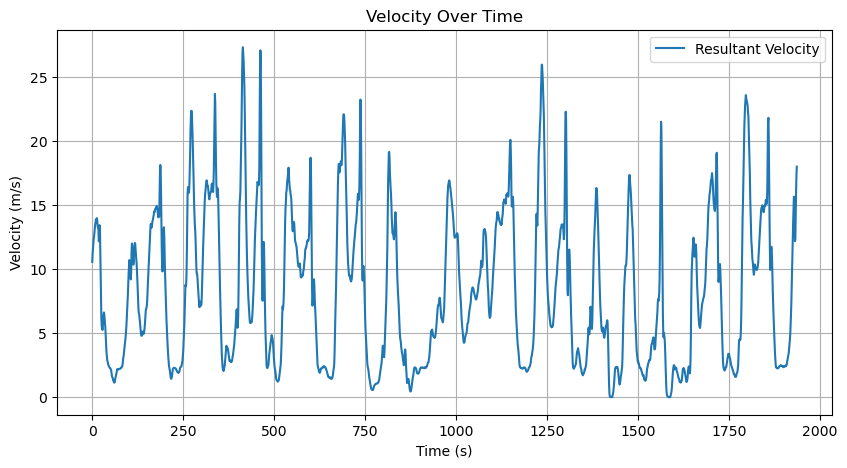

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz


# Estimate initial velocities
v0_x = acc_x[0] * (1 / fs)
v0_y = acc_y[0] * (1 / fs)
v0_z = acc_z[0] * (1 / fs)

# Compute velocity by integrating acceleration
velocity_x = cumtrapz(acc_x, dx=1/fs, initial=v0_x)
velocity_y = cumtrapz(acc_y, dx=1/fs, initial=v0_y)
velocity_z = cumtrapz(acc_z, dx=1/fs, initial=v0_z)

# # Compute velocity by integrating acceleration
# velocity_x = cumtrapz(acc_x, dx=1/fs, initial=0)
# velocity_y = cumtrapz(acc_y, dx=1/fs, initial=0)
# velocity_z = cumtrapz(acc_z, dx=1/fs, initial=0)

# Resultant velocity
velocity_resultant = np.sqrt(velocity_x**2 + velocity_y**2 + velocity_z**2)

# Plot the velocity
plt.figure(figsize=(10, 5))
plt.plot((acc_x_2_trials**2), label="Resultant Velocity")
plt.title("Velocity Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.legend()
plt.grid()
plt.show()

In [ ]:
Visualise.plot_raw_data_with_annotations(
    lfp_raw_list, scaling=5e1, folder_path='images/raw')

In [ ]:
# save all lfp data
with open('processed/all_lfp_data.pkl', 'wb') as f:
    pickle.dump(all_lfp_data, f)
    
with open('processed/lfp_raw_list.pkl', 'wb') as f:
    pickle.dump(lfp_raw_list, f)
    
# save epoched data
epochs.save(f"processed/lfp_{epoch_tmin}tmin_{gap_duration}gap-epo.fif", overwrite=True)
    

In [ ]:
Visualise.plot_event_occurrence(events=events, 
                                epoch_sample_length=epoch_sample_length, 
                                lfp_sfreq=lfp_sfreq, 
                                event_dict=event_dict,
                                # gait_modulation_event_id=mod_start_event_id, 
                                # normal_walking_event_id=normal_walking_event_id, 
                                n_sessions=n_sessions,
                                show_fig=False, 
                                save_fig=True, 
                                file_name=f'images/event_classes.png')


Visualise.plot_event_occurrence(events=epochs.events, 
                                epoch_sample_length=epoch_sample_length, 
                                lfp_sfreq=lfp_sfreq, 
                                event_dict=event_dict,
                                # gait_modulation_event_id=mod_start_event_id, 
                                # normal_walking_event_id=normal_walking_event_id, 
                                n_sessions=n_sessions,
                                show_fig=False, 
                                save_fig=True, 
                                file_name=f'images/epochs.event_classes.png')

In [ ]:
Visualise.plot_event_class_histogram(events=events,
                                    event_dict=epochs.event_id,
                                    n_sessions=n_sessions,
                                    show_fig=False, 
                                    save_fig=True,
                                    file_name=f'images/event_class_histogram.png')

Visualise.plot_event_class_histogram(events=epochs.events,
                                    event_dict=epochs.event_id,
                                    n_sessions=n_sessions,
                                    show_fig=False, 
                                    save_fig=True,
                                    file_name=f'images/epochs.event_class_histogram.png')

# Feature Extraction

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import mne

from gait_modulation.utils.file_reader import MatFileReader
from gait_modulation.utils.data_processor import DataProcessor
from gait_modulation.viz import Visualise
from gait_modulation.utils.feature_extractor import FeatureExtractor

In [ ]:
epochs = mne.read_epochs('processed/lfp_-3.0tmin_5gap-epo.fif')


In [ ]:
epochs.get_data(copy=False).shape

In [ ]:
freq_bands = {
    'delta': (0.1, 3),
    'theta': (4, 7),
    'alpha': (8, 12),
    'low_beta': (12, 16),
    'middle_beta': (16, 20),
    'high_beta': (20, 30),
    'gamma': (30, 100),
    'high_gamma': (100, 125)
}

# Both classes features
psd = FeatureExtractor.extract_band_psd(epochs, freq_bands)
print(psd['gamma'].shape) # ((freq band: {n_epochs, n_channels, n_frequencies})


band_power = FeatureExtractor.extract_band_power(epochs, freq_bands)
print(band_power['delta'].shape) # (freq band: {n_epochs x n_channels})

# ------------------------
# mod_start features
psd_mod_start = FeatureExtractor.extract_band_psd(
    epochs['mod_start'], freq_bands)
print(psd_mod_start['gamma'].shape) # ((freq band: {n_epochs, n_channels, n_frequencies})

band_power_mod_start = FeatureExtractor.extract_band_power(
    epochs['mod_start'], freq_bands)
print(band_power_mod_start['delta'].shape) # (freq band: {n_epochs, n_channels})



# ------------------------
# normal_walking features
psd_normal_walking = FeatureExtractor.extract_band_psd(
    epochs['normal_walking'], freq_bands)
print(psd_normal_walking['gamma'].shape) # ((freq band: {n_epochs, n_channels, n_frequencies})

band_power_normal_walking = FeatureExtractor.extract_band_power(
    epochs['normal_walking'], freq_bands)
print(band_power_normal_walking['delta'].shape) # (freq band: {n_epochs, n_channels})



In [ ]:
print("------")
k=0
for band in freq_bands:
    k += np.sum(band_power[band].shape[1]) 
    print(band_power[band].shape)
k

In [ ]:
def visualize_band_power(band_power_features):
    """
    Visualizes the band power features stored in a dictionary.

    Parameters:
    - band_power_features: dict
        Dictionary where keys are frequency bands and values are arrays of shape (epochs, channels).
    """
    # Set up the figure and axes
    n_bands = len(band_power_features)
    fig, axes = plt.subplots(1, n_bands, figsize=(5 * n_bands, 5), sharey=True)

    for ax, (band, data) in zip(axes, band_power_features.items()):
        # Calculate mean and standard deviation across epochs for each channel
        mean_power = np.mean(data, axis=0)  # Mean across epochs
        std_power = np.std(data, axis=0)    # Std deviation across epochs

        # Plot mean band power for each channel
        ax.plot(mean_power, label=f'Mean Power - {band}', color='blue', marker='o')
        ax.fill_between(range(data.shape[1]), mean_power - std_power, mean_power + std_power, 
                        color='blue', alpha=0.2, label='Std Dev')
        
        ax.set_title(f'Band Power - {band}', fontsize=14)
        ax.set_ylabel('Power (dB)')
        ax.set_xlabel('Channels')
        ax.legend()
        ax.grid(True)

    plt.xticks(ticks=range(data.shape[1]), labels=[f'Channel {i+1}' for i in range(data.shape[1])])
    plt.tight_layout()
    plt.show()

# Assuming `band_power_features` is a dictionary containing the band power data.
visualize_band_power(band_power)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_band_power(band_power_features_mod, band_power_features_norm):
    """
    Visualizes the band power features for mod_start and normal_walking classes.

    Parameters:
    - band_power_features_mod: dict
        Dictionary for mod_start where keys are frequency bands and values are arrays of shape (epochs, channels).
    - band_power_features_norm: dict
        Dictionary for normal_walking where keys are frequency bands and values are arrays of shape (epochs, channels).
    """
    # Set up the figure and axes
    n_bands = len(band_power_features_mod)
    fig, axes = plt.subplots(1, n_bands, figsize=(5 * n_bands, 5), sharey=True)

    for ax, (band, data_mod), (_, data_norm) in zip(axes, band_power_features_mod.items(), band_power_features_norm.items()):
        # Calculate mean across epochs for each channel
        mean_power_mod = np.mean(data_mod, axis=0)  # Mean across epochs for mod_start
        mean_power_norm = np.mean(data_norm, axis=0)  # Mean across epochs for normal_walking

        # Plot mean band power for mod_start
        ax.plot(mean_power_mod, label='mod_start', color='blue', marker='o')

        # Plot mean band power for normal_walking
        ax.plot(mean_power_norm, label='normal_walking', color='orange', marker='o')

        ax.set_title(f'Band Power - {band}', fontsize=14)
        ax.set_ylabel('Power (dB)')
        ax.set_xlabel('Channels')
        ax.legend()
        ax.grid(True)

    plt.xticks(ticks=range(data_mod.shape[1]), labels=[f'Channel {i+1}' for i in range(data_mod.shape[1])])
    plt.tight_layout()
    plt.show()

# Example usage
visualize_band_power(band_power_mod_start, band_power_normal_walking)

In [ ]:
def visualize_psd(psd_features):
    """
    Visualizes the PSD features for each frequency band.
    
    Parameters:
    - psd_features: Dictionary with frequency bands as keys and values as 
                    arrays of shape (n_epochs, n_channels, n_frequencies).
    """
    num_bands = len(psd_features)
    num_channels = next(iter(psd_features.values())).shape[1]  # Get number of channels

    # Create a figure with subplots for each frequency band
    fig, axes = plt.subplots(1, num_bands, figsize=(5 * num_bands, 5), sharey=True)
    
    # Plot each band
    for i, (band, values) in enumerate(psd_features.items()):
        mean_psd = values.mean(axis=0)  # Average across epochs
        freq_range = freq_bands[band]
        freqs = np.linspace(freq_range[0], freq_range[1], values.shape[2])  # Adjust frequency range per band
        
        for ch in range(num_channels):
            axes[i].plot(freqs, mean_psd[ch, :], label=f'Channel {ch + 1}')
        
        # Add titles and labels
        axes[i].set_title(f'PSD Features - {band.capitalize()} band', fontsize=16)
        axes[i].set_xlabel('Frequency (Hz)', fontsize=14)
        if i == 0:
            axes[i].set_ylabel('PSD', fontsize=14)
        axes[i].legend(loc='upper right')
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()

# Example data for testing (use your actual psd_features data here)
visualize_psd(psd)  # Uncomment and run with actual psd_features data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_psd_by_class(psd_features_mod, psd_features_norm, freq_bands):
    """
    Visualizes the PSD features for each frequency band in two subplots, one for each class (mod_start and normal_walking).
    
    Parameters:
    - psd_features_mod: Dictionary for mod_start class with frequency bands as keys and 
                        values as arrays of shape (n_epochs, n_channels, n_frequencies).
    - psd_features_norm: Dictionary for normal_walking class with frequency bands as keys and 
                         values as arrays of shape (n_epochs, n_channels, n_frequencies).
    - freq_bands: Dictionary of frequency bands with their ranges.
    """
    num_bands = len(freq_bands)
    num_channels_mod = next(iter(psd_features_mod.values())).shape[1]  # Number of channels for mod_start
    num_channels_norm = next(iter(psd_features_norm.values())).shape[1]  # Number of channels for normal_walking

    fig, axes = plt.subplots(2, num_bands, figsize=(5 * num_bands, 10), sharey=True)

    # Plot PSD for mod_start
    for i, (band, values_mod) in enumerate(psd_features_mod.items()):
        mean_psd_mod = values_mod.mean(axis=0)  # Average across epochs for mod_start
        freq_range = freq_bands[band]
        freqs = np.linspace(freq_range[0], freq_range[1], values_mod.shape[2])  # Set frequency range per band
        
        for ch in range(num_channels_mod):
            axes[0, i].plot(freqs, mean_psd_mod[ch, :], label=f'Channel {ch + 1}')
        
        # Add titles and labels for mod_start class
        axes[0, i].set_title(f'mod_start - {band.capitalize()}', fontsize=14)
        axes[0, i].set_xlabel('Frequency (Hz)', fontsize=12)
        if i == 0:
            axes[0, i].set_ylabel('PSD', fontsize=12)
        axes[0, i].grid(True)

    # Plot PSD for normal_walking
    for i, (band, values_norm) in enumerate(psd_features_norm.items()):
        mean_psd_norm = values_norm.mean(axis=0)  # Average across epochs for normal_walking
        freq_range = freq_bands[band]
        freqs = np.linspace(freq_range[0], freq_range[1], values_norm.shape[2])  # Set frequency range per band
        
        for ch in range(num_channels_norm):
            axes[1, i].plot(freqs, mean_psd_norm[ch, :], label=f'Channel {ch + 1}')
        
        # Add titles and labels for normal_walking class
        axes[1, i].set_title(f'normal_walking - {band.capitalize()}', fontsize=14)
        axes[1, i].set_xlabel('Frequency (Hz)', fontsize=12)
        if i == 0:
            axes[1, i].set_ylabel('PSD', fontsize=12)
        axes[1, i].grid(True)

    # Add legends and adjust layout
    for ax in axes.flat:
        ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Example usage:
psd_features_mod_start = FeatureExtractor.extract_band_psd(epochs['mod_start'], freq_bands)
psd_features_normal_walking = FeatureExtractor.extract_band_psd(epochs['normal_walking'], freq_bands)

visualize_psd_by_class(psd_features_mod_start, psd_features_normal_walking, freq_bands)  # Uncomment with actual data

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# def visualize_psd_by_class(psd_features_mod, psd_features_norm, freq_bands):
#     """
#     Visualizes the PSD features for each frequency band in two subplots, one for each class (mod_start and normal_walking),
#     with frequency bands spread along the y-axis.
    
#     Parameters:
#     - psd_features_mod: Dictionary for mod_start class with frequency bands as keys and 
#                         values as arrays of shape (n_epochs, n_channels, n_frequencies).
#     - psd_features_norm: Dictionary for normal_walking class with frequency bands as keys and 
#                          values as arrays of shape (n_epochs, n_channels, n_frequencies).
#     - freq_bands: Dictionary of frequency bands with their ranges.
#     """
#     num_bands = len(freq_bands)
#     num_channels_mod = next(iter(psd_features_mod.values())).shape[1]  # Number of channels for mod_start
#     num_channels_norm = next(iter(psd_features_norm.values())).shape[1]  # Number of channels for normal_walking

#     fig, axes = plt.subplots(num_bands, 2, figsize=(10, 5 * num_bands), sharey=True)

#     # Plot each frequency band on a separate row
#     for i, (band, values_mod) in enumerate(psd_features_mod.items()):
#         # Define frequency range for this band
#         freq_range = freq_bands[band]
#         freqs = np.linspace(freq_range[0], freq_range[1], values_mod.shape[2])

#         # Plot mod_start PSD in the left column
#         mean_psd_mod = values_mod.mean(axis=0)  # Average across epochs
#         for ch in range(num_channels_mod):
#             axes[i, 0].plot(freqs, mean_psd_mod[ch, :], label=f'Channel {ch + 1}')
        
#         # Add title and labels for mod_start
#         axes[i, 0].set_title(f'{band.capitalize()} - mod_start', fontsize=14)
#         axes[i, 0].set_ylabel('PSD', fontsize=12)
#         axes[i, 0].grid(True)
#         if i == num_bands - 1:
#             axes[i, 0].set_xlabel('Frequency (Hz)', fontsize=12)

#         # Plot normal_walking PSD in the right column
#         values_norm = psd_features_norm[band]
#         mean_psd_norm = values_norm.mean(axis=0)  # Average across epochs
#         for ch in range(num_channels_norm):
#             axes[i, 1].plot(freqs, mean_psd_norm[ch, :], label=f'Channel {ch + 1}')
        
#         # Add title and labels for normal_walking
#         axes[i, 1].set_title(f'{band.capitalize()} - normal_walking', fontsize=14)
#         axes[i, 1].grid(True)
#         if i == num_bands - 1:
#             axes[i, 1].set_xlabel('Frequency (Hz)', fontsize=12)

#     # Add legends and adjust layout
#     for ax in axes.flat:
#         ax.legend(loc='upper right')

#     plt.tight_layout()
#     plt.show()

# psd_features_mod_start = FeatureExtractor.extract_band_psd(epochs['mod_start'], freq_bands)
# psd_features_normal_walking = FeatureExtractor.extract_band_psd(epochs['normal_walking'], freq_bands)

# visualize_psd_by_class(psd_features_mod_start, psd_features_normal_walking, freq_bands)  # Uncomment with actual data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_psd_by_class(psd_features_mod, psd_features_norm, freq_bands):
    """
    Visualizes the PSD features for each frequency band in two subplots, one for each class (mod_start and normal_walking),
    with frequency bands spread along the y-axis. Includes individual channel plots with an overlay of the mean and
    standard deviation across channels.
    
    Parameters:
    - psd_features_mod: Dictionary for mod_start class with frequency bands as keys and 
                        values as arrays of shape (n_epochs, n_channels, n_frequencies).
    - psd_features_norm: Dictionary for normal_walking class with frequency bands as keys and 
                         values as arrays of shape (n_epochs, n_channels, n_frequencies).
    - freq_bands: Dictionary of frequency bands with their ranges.
    """
    num_bands = len(freq_bands)
    num_channels_mod = next(iter(psd_features_mod.values())).shape[1]  # Number of channels for mod_start
    num_channels_norm = next(iter(psd_features_norm.values())).shape[1]  # Number of channels for normal_walking

    fig, axes = plt.subplots(num_bands, 2, figsize=(10, 5 * num_bands), sharey='row')

    # Plot each frequency band on a separate row
    for i, (band, values_mod) in enumerate(psd_features_mod.items()):
        # Define frequency range for this band
        freq_range = freq_bands[band]
        freqs = np.linspace(freq_range[0], freq_range[1], values_mod.shape[2])

        # Plot mod_start PSD for each channel
        mean_psd_mod = values_mod.mean(axis=0)  # Average across epochs
        std_psd_mod = values_mod.std(axis=0)  # Standard deviation across epochs
        mean_across_channels_mod = mean_psd_mod.mean(axis=0)  # Mean across channels
        std_across_channels_mod = mean_psd_mod.std(axis=0)  # Std across channels
        
        for ch in range(num_channels_mod):
            axes[i, 0].plot(freqs, mean_psd_mod[ch, :], label=f'Channel {ch + 1}', alpha=0.6)

        # Overlay mean line and standard deviation shading for mod_start
        axes[i, 0].plot(freqs, mean_across_channels_mod, color='black', linewidth=2, label='Mean')
        axes[i, 0].fill_between(freqs, mean_across_channels_mod - std_across_channels_mod,
                                mean_across_channels_mod + std_across_channels_mod, color='gray', alpha=0.3, label='±1 STD')
        
        # Add title and labels for mod_start
        axes[i, 0].set_title(f'{band.capitalize()} - mod_start', fontsize=14)
        axes[i, 0].set_ylabel('PSD', fontsize=12)
        axes[i, 0].grid(True)
        if i == num_bands - 1:
            axes[i, 0].set_xlabel('Frequency (Hz)', fontsize=12)

        # Plot normal_walking PSD for each channel
        values_norm = psd_features_norm[band]
        mean_psd_norm = values_norm.mean(axis=0)  # Average across epochs
        std_psd_norm = values_norm.std(axis=0)  # Standard deviation across epochs
        mean_across_channels_norm = mean_psd_norm.mean(axis=0)  # Mean across channels
        std_across_channels_norm = mean_psd_norm.std(axis=0)  # Std across channels
        
        for ch in range(num_channels_norm):
            axes[i, 1].plot(freqs, mean_psd_norm[ch, :], label=f'Channel {ch + 1}', alpha=0.6)
        
        # Overlay mean line and standard deviation shading for normal_walking
        axes[i, 1].plot(freqs, mean_across_channels_norm, color='black', linewidth=2, label='Mean')
        axes[i, 1].fill_between(freqs, mean_across_channels_norm - std_across_channels_norm,
                                mean_across_channels_norm + std_across_channels_norm, color='gray', alpha=0.3, label='±1 STD')

        # Add title and labels for normal_walking
        axes[i, 1].set_title(f'{band.capitalize()} - normal_walking', fontsize=14)
        axes[i, 1].grid(True)
        if i == num_bands - 1:
            axes[i, 1].set_xlabel('Frequency (Hz)', fontsize=12)

    # Add legends and adjust layout
    for ax in axes.flat:
        ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Example usage:
psd_features_mod_start = FeatureExtractor.extract_band_psd(epochs['mod_start'], freq_bands)
psd_features_normal_walking = FeatureExtractor.extract_band_psd(epochs['normal_walking'], freq_bands)

visualize_psd_by_class(psd_features_mod_start, psd_features_normal_walking, freq_bands)  # Uncomment with actual data

In [ ]:
def plot_overall_psd_with_bands(epochs, freq_bands, fmin=1, fmax=50):
    """
    Plots the overall PSD averaged across epochs for each channel, and marks the frequency bands with different colors and annotations.

    Parameters:
    - epochs: mne.Epochs object containing the LFP data.
    - freq_bands: Dictionary where keys are the band names, and values are tuples with (low_freq, high_freq).
    - fmin: Minimum frequency to compute PSD (default=1 Hz).
    - fmax: Maximum frequency to compute PSD (default=50 Hz).
    """
    # Compute PSD across all epochs and channels, averaging across epochs
    psds, freqs = epochs.compute_psd(fmin=fmin, fmax=fmax).get_data(return_freqs=True)
    psds_mean = psds.mean(axis=0)  # Average across epochs
    
    # Colors for the frequency bands
    band_colors = ['lightblue', 'lightgreen', 'lightcoral', 'gold', 'lightpink']

    # Plot overall PSD for each channel
    fig, ax = plt.subplots(figsize=(10, 6))
    for ch in range(psds_mean.shape[0]):  # Iterate over channels
        ax.plot(freqs, 10 * np.log10(psds_mean[ch]), label=f'Channel {ch+1}')

    # Mark frequency bands with distinct colors and create a secondary x-axis for band names
    for i, (band, (low, high)) in enumerate(freq_bands.items()):
        ax.axvspan(low, high, color=band_colors[i % len(band_colors)], alpha=0.3)

    # Add secondary x-axis to display band names
    ax_top = ax.secondary_xaxis('top')
    ax_top.set_xticks([np.mean([low, high]) for low, high in freq_bands.values()])  # Place ticks at the center of each band
    ax_top.set_xticklabels(freq_bands.keys())  # Set the band names as labels
    ax_top.tick_params(axis='x', pad=10)  # Adjust padding of the labels

    # Set labels and title
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power Spectral Density (dB)')
    ax.set_title('Overall PSD Averaged Across Epochs for Each Channel')
    
    plt.grid(True)
    plt.show()

# Example usage:
# Assuming `epochs` is your MNE Epochs object and `freq_bands` is a dictionary of frequency bands
plot_overall_psd_with_bands(epochs, 
                            freq_bands,
                            fmin=freq_bands['delta'][0],
                            fmax=freq_bands['high_gamma'][1])

In [ ]:
def plot_overall_psd_with_bands_by_class(epochs_mod, epochs_norm, freq_bands, fmin=1, fmax=50):
    """
    Plots the overall PSD for two classes (mod_start and normal_walking) in separate subplots,
    averaged across epochs for each class and channel. Frequency bands are marked with distinct colors.

    Parameters:
    - epochs_mod: MNE Epochs object for the mod_start class.
    - epochs_norm: MNE Epochs object for the normal_walking class.
    - freq_bands: Dictionary where keys are the band names, and values are tuples with (low_freq, high_freq).
    - fmin: Minimum frequency to compute PSD (default=1 Hz).
    - fmax: Maximum frequency to compute PSD (default=50 Hz).
    """

    # Compute PSD for mod_start class
    psds_mod, freqs_mod = epochs_mod.compute_psd(fmin=fmin, fmax=fmax).get_data(return_freqs=True)
    psds_mod_mean = psds_mod.mean(axis=0)  # Average across epochs for mod_start

    # Compute PSD for normal_walking class
    psds_norm, freqs_norm = epochs_norm.compute_psd(fmin=fmin, fmax=fmax).get_data(return_freqs=True)
    psds_norm_mean = psds_norm.mean(axis=0)  # Average across epochs for normal_walking

    # Colors for the frequency bands
    band_colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightpink']

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

    # Plot PSD for mod_start
    for ch in range(psds_mod_mean.shape[0]):
        axes[0].plot(freqs_mod, 10 * np.log10(psds_mod_mean[ch]), label=f'Channel {ch+1}')
    axes[0].set_title('PSD for mod_start')
    axes[0].set_xlabel('Frequency (Hz)')
    axes[0].set_ylabel('Power Spectral Density (dB)')
    for i, (band, (low, high)) in enumerate(freq_bands.items()):
        axes[0].axvspan(low, high, color=band_colors[i % len(band_colors)], alpha=0.3)
    ax_top_mod = axes[0].secondary_xaxis('top')
    ax_top_mod.set_xticks([np.mean([low, high]) for low, high in freq_bands.values()])
    ax_top_mod.set_xticklabels(freq_bands.keys())
    ax_top_mod.tick_params(axis='x', pad=10)

    # Plot PSD for normal_walking
    for ch in range(psds_norm_mean.shape[0]):
        axes[1].plot(freqs_norm, 10 * np.log10(psds_norm_mean[ch]), label=f'Channel {ch+1}')
    axes[1].set_title('PSD for normal_walking')
    axes[1].set_xlabel('Frequency (Hz)')
    for i, (band, (low, high)) in enumerate(freq_bands.items()):
        axes[1].axvspan(low, high, color=band_colors[i % len(band_colors)], alpha=0.3)
    ax_top_norm = axes[1].secondary_xaxis('top')
    ax_top_norm.set_xticks([np.mean([low, high]) for low, high in freq_bands.values()])
    ax_top_norm.set_xticklabels(freq_bands.keys())
    ax_top_norm.tick_params(axis='x', pad=10)

    plt.tight_layout()
    plt.show()

# Example usage:
plot_overall_psd_with_bands_by_class(epochs['mod_start'],
                                     epochs['normal_walking'], freq_bands,                             fmin=freq_bands['delta'][0],
                                     fmax=freq_bands['high_gamma'][1])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_overall_psd_with_bands_by_class(epochs_mod, epochs_norm, freq_bands, fmin=1, fmax=50):
    """
    Plots the overall PSD for two classes (mod_start and normal_walking) in one plot,
    averaged across epochs and channels. Frequency bands are marked with distinct colors.

    Parameters:
    - epochs_mod: MNE Epochs object for the mod_start class.
    - epochs_norm: MNE Epochs object for the normal_walking class.
    - freq_bands: Dictionary where keys are the band names, and values are tuples with (low_freq, high_freq).
    - fmin: Minimum frequency to compute PSD (default=1 Hz).
    - fmax: Maximum frequency to compute PSD (default=50 Hz).
    """

    # Compute PSD for mod_start class
    psds_mod, freqs_mod = epochs_mod.compute_psd(fmin=fmin, fmax=fmax).get_data(return_freqs=True)
    psds_mod_mean = psds_mod.mean(axis=(0, 1))  # Average across epochs and channels

    # Compute PSD for normal_walking class
    psds_norm, freqs_norm = epochs_norm.compute_psd(fmin=fmin, fmax=fmax).get_data(return_freqs=True)
    psds_norm_mean = psds_norm.mean(axis=(0, 1))  # Average across epochs and channels

    # Colors for the frequency bands
    band_colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightpink']

    # Create figure
    plt.figure(figsize=(10, 6))

    # Plot the mean PSD for mod_start
    plt.plot(freqs_mod, 10 * np.log10(psds_mod_mean), color='blue', label='mod_start (mean)', linewidth=2)

    # Plot the mean PSD for normal_walking
    plt.plot(freqs_norm, 10 * np.log10(psds_norm_mean), color='orange', label='normal_walking (mean)', linewidth=2)

    # Mark frequency bands with shaded regions
    for i, (band, (low, high)) in enumerate(freq_bands.items()):
        plt.axvspan(low, high, color=band_colors[i % len(band_colors)], alpha=0.3)

    # Top x-axis for frequency bands
    ax_top = plt.gca().secondary_xaxis('top')
    ax_top.set_xticks([np.mean([low, high]) for low, high in freq_bands.values()])
    ax_top.set_xticklabels(freq_bands.keys())
    ax_top.tick_params(axis='x', pad=10)

    # Plot settings
    plt.title('PSD Comparison for mod_start and normal_walking')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (dB)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_overall_psd_with_bands_by_class(epochs['mod_start'],
                                     epochs['normal_walking'],
                                     freq_bands,
                                     fmin=freq_bands['delta'][0],
                                     fmax=freq_bands['high_gamma'][1])

In [ ]:
import mne
import numpy as np
import matplotlib.pyplot as plt

def visualize_band_power_combined(band_power_features, sfreq, ch_names):
    """
    Visualizes the band power features stored in a dictionary in a single plot,
    with each trace representing a channel and the x-axis representing frequency bands.

    Parameters:
    - band_power_features: dict
        Dictionary where keys are frequency bands and values are arrays of shape (epochs, channels).
    - sfreq: float
        Sampling frequency of the data.
    - ch_names: list
        List of channel names corresponding to the data.
    """
    # Create a new figure
    plt.figure(figsize=(12, 6))

    # Prepare the x-axis (frequency bands)
    freq_bands = list(band_power_features.keys())
    num_bands = len(freq_bands)

    # Prepare the y-axis data for each channel
    for ch_idx, ch_name in enumerate(ch_names):
        # Extract band power data for this channel
        channel_band_power = [band_power_features[band][:, ch_idx].mean() for band in freq_bands]

        # Plot each channel's band power across frequency bands
        plt.plot(freq_bands, channel_band_power, marker='o', label=ch_name)

    # Add titles and labels
    plt.title('Band Power Across Frequency Bands', fontsize=16)
    plt.xlabel('Frequency Bands', fontsize=14)
    plt.ylabel('Average Power (dB)', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid()
    plt.legend(title='Channels', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming `band_power_features` is your dictionary containing the band power data,
# `sfreq` is your sampling frequency, and `ch_names` is your list of channel names.
visualize_band_power_combined(band_power, lfp_sfreq, lfp_ch_names)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_band_power(band_power_features_mod, band_power_features_norm):
    """
    Visualizes the band power features for mod_start and normal_walking classes.

    Parameters:
    - band_power_features_mod: dict
        Dictionary for mod_start where keys are frequency bands and values are arrays of shape (epochs, channels).
    - band_power_features_norm: dict
        Dictionary for normal_walking where keys are frequency bands and values are arrays of shape (epochs, channels).
    """
    # Set up the figure and axes
    n_bands = len(band_power_features_mod)
    fig, axes = plt.subplots(1, n_bands, figsize=(5 * n_bands, 5), sharey=True)

    for ax, (band, data_mod), (_, data_norm) in zip(axes, band_power_features_mod.items(), band_power_features_norm.items()):
        # Calculate mean and standard deviation across epochs for each channel for mod_start
        mean_power_mod = np.mean(data_mod, axis=0)  # Mean across epochs
        std_power_mod = np.std(data_mod, axis=0)    # Std deviation across epochs
        
        # Calculate mean and standard deviation across epochs for each channel for normal_walking
        mean_power_norm = np.mean(data_norm, axis=0)  # Mean across epochs
        std_power_norm = np.std(data_norm, axis=0)    # Std deviation across epochs

        # Plot mean band power for mod_start
        ax.plot(mean_power_mod, label=f'Mean Power - mod_start', color='blue', marker='o')
        ax.fill_between(range(data_mod.shape[1]), mean_power_mod - std_power_mod, mean_power_mod + std_power_mod, 
                        color='blue', alpha=0.2, label='Std Dev - mod_start')

        # Plot mean band power for normal_walking
        ax.plot(mean_power_norm, label=f'Mean Power - normal_walking', color='orange', marker='o')
        ax.fill_between(range(data_norm.shape[1]), mean_power_norm - std_power_norm, mean_power_norm + std_power_norm, 
                        color='orange', alpha=0.2, label='Std Dev - normal_walking')

        ax.set_title(f'Band Power - {band}', fontsize=14)
        ax.set_ylabel('Power (dB)')
        ax.set_xlabel('Channels')
        ax.legend()
        ax.grid(True)

    plt.xticks(ticks=range(data_mod.shape[1]), labels=[f'Channel {i+1}' for i in range(data_mod.shape[1])])
    plt.tight_layout()
    plt.show()

# Example usage
visualize_band_power(band_power_mod_start, band_power_normal_walking)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_band_power_mean_std(band_power_features):
    """
    Visualizes the mean and standard deviation of band power features across channels
    in a single plot, with each trace representing the mean and std across channels.

    Parameters:
    - band_power_features: dict
        Dictionary where keys are frequency bands and values are arrays of shape (epochs, channels).
    """
    # Create a new figure
    plt.figure(figsize=(12, 6))

    # Prepare the x-axis (frequency bands)
    freq_bands = list(band_power_features.keys())

    # Prepare the y-axis data for mean and std across channels
    mean_band_power = []
    std_band_power = []

    for band in freq_bands:
        # Compute the mean and standard deviation across channels for the current frequency band
        mean_power = band_power_features[band].mean(axis=1)  # Mean across channels
        std_power = band_power_features[band].std(axis=1)    # Std across channels
        
        mean_band_power.append(mean_power)  # Append the mean values
        std_band_power.append(std_power)      # Append the std values

    mean_band_power = np.array(mean_band_power)
    std_band_power = np.array(std_band_power)

    # Mean and std for plotting should be calculated correctly
    mean_band_power_mean = mean_band_power.mean(axis=1)
    mean_band_power_std = mean_band_power.std(axis=1)

    # Plotting the mean
    plt.plot(freq_bands, mean_band_power_mean, marker='o', label='Mean', color='blue')

    # Plotting the standard deviation as shaded area
    plt.fill_between(freq_bands, 
                     mean_band_power_mean - mean_band_power_std, 
                     mean_band_power_mean + mean_band_power_std, 
                     color='blue', alpha=0.3, label='Std Dev')

    # Add titles and labels
    plt.title('Mean Band Power Across Frequency Bands', fontsize=16)
    plt.xlabel('Frequency Bands', fontsize=14)
    plt.ylabel('Average Power (dB)', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid()
    plt.legend(title='Statistics')

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming `band_power_features` is your dictionary containing the band power data.
visualize_band_power_mean_std(band_power)

In [ ]:
# Plot and save for 'mod_start' event
figs_mod_start = epochs['mod_start'].plot_image(picks=[0, 1, 2, 3, 4, 5], title='Mod Start Epochs TFR')
for i, fig in enumerate(figs_mod_start):
    fig.savefig(f'images/epochs_tfr/mod_start_plot_epochs_tfr_pick{i}.png')

# Plot and save for 'normal_walking' event
figs_normal_walking = epochs['normal_walking'].plot_image(picks=[0, 1, 2, 3, 4, 5], title='Normal Walking Epochs TFR')
for i, fig in enumerate(figs_normal_walking):
    fig.savefig(f'images/epochs_tfr/normal_walking_plot_epochs_tfr_pick{i}.png')


In [ ]:
epochs['normal_walking'].plot_image()

In [ ]:
epochs['normal_walking'].plot_image(picks=[0,1,2,3,4,5])


In [ ]:
# bad_epoch = np.argmin(epochs['mod_start'].get_data()[76, 5,:]) 
# # epochs[76, 5, 54] = np.mean(epochs['mod_start'].get_data()[76, 5,:])
# # epochs['mod_start'].get_data()[76, 5, 54]
# epochs.drop(bad_epoch)

In [ ]:
# # def remove_outliers(epochs, threshold=3):

# # Compute the mean and standard deviation across epochs
# data = epochs.get_data()  # shape: (n_epochs, n_channels, n_times)
# threshold=3

# # Reshape to (n_epochs, n_channels * n_times)
# reshaped_data = data.reshape(data.shape[0], -1)

# # Calculate z-scores
# z_scores = np.abs((reshaped_data - np.mean(reshaped_data, axis=0)) / np.std(reshaped_data, axis=0))

# # Identify outlier epochs
# outlier_epochs = np.where(z_scores > threshold)

# # Remove outlier epochs
# clean_epochs = epochs.copy().drop(outlier_epochs[0])

# # cleaned_epochs = remove_outliers(epochs)

# Statistical Analysis

## T-Test on Band Power Features

In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Initialize results storage
t_stats = {}
p_values = {}

# Loop through each frequency band
for band in band_power_mod_start.keys():
    # Average across epochs (axis=0) and channels (axis=1)
    mean_mod = np.mean(band_power_mod_start[band], axis=0)
    mean_norm = np.mean(band_power_normal_walking[band], axis=0)
    
    # Perform a t-test
    t_stat, p_value = stats.ttest_ind(mean_mod, mean_norm)
    
    # Store the results
    t_stats[band] = t_stat
    p_values[band] = p_value

# Display results
for band in t_stats.keys():
    print(f'Band {band}: T-statistic: {t_stats[band]:.4f}, P-value: {p_values[band]:.4f}')

## T-Test on PSD Features

In [ ]:
# Initialize results storage
t_stats_psd = {}
p_values_psd = {}

# Loop through each frequency band
for band in psd_features_mod_start.keys():
    # Average across epochs (axis=0) and channels (axis=1) for each frequency
    mean_psd_mod = np.mean(psd_features_mod_start[band], axis=(0, 1))  # Mean across epochs and channels
    mean_psd_norm = np.mean(psd_features_normal_walking[band], axis=(0, 1))  # Mean across epochs and channels
    
    # Perform a t-test
    t_stat_psd, p_value_psd = stats.ttest_ind(mean_psd_mod, mean_psd_norm)
    
    # Store the results
    t_stats_psd[band] = t_stat_psd
    p_values_psd[band] = p_value_psd

# Display results
for band in t_stats_psd.keys():
    print(f'Band: {band}, T-statistic: {t_stats_psd[band]:.4f}, P-value: {p_values_psd[band]:.4f}')

# Baseline Model (LogisticRegression)

In [ ]:
print(epochs.get_data().shape)
print(epochs['mod_start'].get_data().shape)
print(epochs['normal_walking'].get_data().shape)

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

# Assuming epochs are in the shape (n_epochs, n_channels, n_frequencies)
# Convert your epochs data into a suitable format for classification
# For this example, we'll use the 'mod_start' and 'normal_walking' classes

# Load your data
X_mod_start = epochs['mod_start'].get_data(copy=True)  # Shape: (147, 6, 501)
X_normal_walking = epochs['normal_walking'].get_data(copy=True)  # Shape: (610, 6, 501)

# Combine the data and create labels
X = np.concatenate((X_mod_start, X_normal_walking), axis=0)  # Shape: (757, 6, 501)
y = np.array([0] * X_mod_start.shape[0] + [1] * X_normal_walking.shape[0])  # 0 for mod_start, 1 for normal_walking

# Flatten the data across channels and frequencies for classification
n_epochs = X.shape[0]
X_flat = X.reshape(n_epochs, -1)  # Shape: (757, 6 * 501)

# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5)

# Initialize model
model = LogisticRegression(max_iter=1000)

# Store the results
scores = []

# Perform Stratified K-Fold Cross-Validation
for train_index, test_index in skf.split(X_flat, y):
    X_train, X_test = X_flat[train_index], X_flat[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions and evaluate
    predictions = model.predict(X_test)
    score = accuracy_score(y_test, predictions)
    scores.append(score)

# Average accuracy across folds
mean_score = np.mean(scores)
print(f'Mean accuracy: {mean_score:.2f}')

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression  # Example model; you can replace it with your model
from sklearn.preprocessing import StandardScaler

# Assuming X is your features and y are the labels
X = epochs.get_data(copy=True).reshape(epochs.get_data(copy=True).shape[0], -1)  # Reshape to (n_epochs, n_channels * n_features)
y = np.array([0] * epochs['mod_start'].get_data(copy=True).shape[0] + [1] * epochs['normal_walking'].get_data(copy=True).shape[0])  # Example labels

# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5)  # You can choose any number of splits
metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'confusion_matrices': []
}

# Stratified K-Fold Cross-Validation
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Optional: Scale your features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train your model
    model = LogisticRegression()  # Example model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    metrics['accuracy'].append(accuracy_score(y_test, y_pred))
    metrics['precision'].append(precision_score(y_test, y_pred, average='weighted'))
    metrics['recall'].append(recall_score(y_test, y_pred, average='weighted'))
    metrics['f1'].append(f1_score(y_test, y_pred, average='weighted'))
    metrics['confusion_matrices'].append(confusion_matrix(y_test, y_pred))

# Calculate mean and standard deviation for metrics
for key in metrics:
    if key != 'confusion_matrices':
        print(f"{key.capitalize()} - Mean: {np.mean(metrics[key]):.2f}, Std: {np.std(metrics[key]):.2f}")
    else:
        # Print confusion matrices
        for i, cm in enumerate(metrics['confusion_matrices']):
            print(f"Confusion Matrix for fold {i + 1}:\n{cm}\n")

In [ ]:
X.shape, y.shape

In [ ]:
epochs['mod_start'].get_data().shape, epochs['normal_walking'].get_data().shape

## 2. Temporal models - LSTM Model

In [ ]:
import tensorflow as tf
print(tf.__version__)

physical_devices = tf.config.list_physical_devices('GPU')
print("Available GPUs:", physical_devices)

if physical_devices:
    print("Using GPU")
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No GPU detected. Using CPU.")

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Prepare the Data
# Assuming epochs is already defined and contains your data.
X_mod = epochs['mod_start'].get_data()  # Shape: (147, 6, 501)
X_norm = epochs['normal_walking'].get_data()  # Shape: (610, 6, 501)

# Stack your data
X = np.concatenate([X_mod, X_norm], axis=0)  # Shape: (757, 6, 501)
y = np.concatenate([np.zeros(X_mod.shape[0]), np.ones(X_norm.shape[0])])  # Labels: 0 for mod_start, 1 for normal_walking

# Step 2: Define the LSTM Model
def create_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(32))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # For binary classification
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Step 3: Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5)

all_metrics = []

# Step 4: Initialize a list to store history
histories = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Reshape the data for LSTM input
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

    model = create_model((X_train.shape[1], X_train.shape[2]))
    
    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    # Step 5: Train the Model and save history
    history = model.fit(X_train,
                        y_train,
                        epochs=50,
                        batch_size=32,
                        validation_data=(X_test, y_test),
                        # callbacks=[early_stopping],
                        )
    
    histories.append(history.history)  # Store history for plotting
    
    # Step 6: Evaluate the Model
    y_pred = (model.predict(X_test) > 0.5).astype("int32")  # Threshold at 0.5 for binary classification
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    all_metrics.append((accuracy, precision, recall, f1))

    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['mod_start', 'normal_walking'], yticklabels=['mod_start', 'normal_walking'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
# Step 8: Plotting Learning Progress
# Check minimum length of history entries
min_length = min(len(history['loss']) for history in histories)

# Truncate histories to the minimum length
avg_train_loss = np.mean([history['loss'][:min_length] for history in histories], axis=0)
avg_val_loss = np.mean([history['val_loss'][:min_length] for history in histories], axis=0)
avg_train_accuracy = np.mean([history['accuracy'][:min_length] for history in histories], axis=0)
avg_val_accuracy = np.mean([history['val_accuracy'][:min_length] for history in histories], axis=0)

# Plot Loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(avg_train_loss, label='Train Loss', color='blue')
plt.plot(avg_val_loss, label='Validation Loss', color='orange')
plt.title('Loss Progression')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(avg_train_accuracy, label='Train Accuracy', color='blue')
plt.plot(avg_val_accuracy, label='Validation Accuracy', color='orange')
plt.title('Accuracy Progression')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Filtering the data

In [ ]:
# raw psd
raw_spectrum = raw_data_clean.compute_psd(method='welch', fmin=1, fmax=50, n_fft=2048)

psd_arr = raw_spectrum.get_data()
psd_freqs = raw_spectrum.freqs
print(raw_data_clean.get_data().shape)
print(f"PSD data has shape: {psd_arr.shape}  # channels x frequencies")
print(f"Frequencies has shape: {psd_freqs.shape}  # frequencies")

raw_spectrum.plot()

In [ ]:
raw_spectrum.get_data().shape, raw_data_clean.get_data().shape

In [ ]:
# epochs psd: Train set
train_epoch_spectrum = train_all_epochs_combined.compute_psd(method='welch', fmax=50)

psd_arr = train_epoch_spectrum.get_data()
psd_freqs = train_epoch_spectrum.freqs

print(train_all_epochs_combined.get_data().shape)
print(f"PSD data has shape: {psd_arr.shape}")
print(f"Frequencies has shape: {psd_freqs.shape}")

train_epoch_spectrum.plot(average=False)

In [ ]:
train_epoch_spectrum['mod_start'].plot(average=False)

In [ ]:
train_epoch_spectrum['normal_walking'].plot(average=False)

In [ ]:
# epochs psd: Test set
test_epoch_spectrum = test_all_epochs_combined.compute_psd(method='welch', fmax=50)

psd_arr = test_epoch_spectrum.get_data()
psd_freqs = test_epoch_spectrum.freqs

print(test_all_epochs_combined.get_data().shape)
print(f"PSD data has shape: {psd_arr.shape}")
print(f"Frequencies has shape: {psd_freqs.shape}")

test_epoch_spectrum.plot(average=False)

In [ ]:
test_epoch_spectrum['mod_start'].plot(average=False)

In [ ]:
test_epoch_spectrum['normal_walking'].plot(average=False)

In [ ]:
train_all_epochs_combined.get_data().shape, train_epoch_spectrum.get_data().shape



# train_all_epochs_combined.events[:, -1].shape, test_all_epochs_combined.events[:, -1].shape

## Logistic Regression based on PSD

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report


# Step 1: Train-test split
X_train = train_epoch_spectrum.get_data()
X_test = test_epoch_spectrum.get_data()

y_train = train_all_epochs_combined.events[:, -1]
y_test = test_all_epochs_combined.events[:, -1]

print(f'X_train shape: {X_train.shape}')# (n_epochs, n_channels, n_samples_per_epoch)
print(f'y_train shape: {y_train.shape}')  # (n_epochs,)
print(f'--- Total epochs: {len(y_train)}, with {sum(y_train == -1)} normal walking and {sum(y_train == 1)} event-related gait modulation')

print(f'X_test shape: {X_test.shape}')# (n_epochs, n_channels, n_samples_per_epoch)
print(f'y_test shape: {y_test.shape}')  # (n_epochs,)
print(f'--- Total epochs: {len(y_train)}, with {sum(y_test == -1)} normal walking and {sum(y_test == 1)} event-related gait modulation')

# Step 2: Flatten the X array (n_epochs, n_channels, n_samples_per_epoch) -> (n_epochs, n_channels * n_samples_per_epoch)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])


# Step 3: Standardize the features (mean=0, std=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train a Logistic Regression model
clf = LogisticRegression(random_state=42, max_iter=1000)
clf.fit(X_train_scaled, y_train)

# Step 5: Make predictions
y_pred = clf.predict(X_test)

# Step 6: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Output the results
print(f'Accuracy: {accuracy:.4f}')
print('Confusion Matrix:')
print(conf_matrix)

# Output the classification report
print(classification_report(y_test, y_pred))

In [ ]:
# ICA raw
## CODE GOES HERE
ica_95PCA = mne.preprocessing.ICA(n_components=0.95, random_state=0)
ica_95PCA.fit(inst=lfp_raw)
# ica_95PCA.plot_sources(inst=lfp_raw, title="ICA sources (95% variance PCA components)");

In [ ]:
# raw_ica_excluded = ica.apply(inst=lfp_raw.copy())
# raw_ica = ica.apply(inst=lfp_raw.copy())

# raw_ica_excluded.plot(scalings='auto', start=12, duration=4, title='clraned sensor signals (without noise)')
# raw_ica.plot(scalings='auto', start=12, duration=4, title='clraned sensor signals (without noise)')

In [ ]:
# # ICA rpochs
# ## CODE GOES HERE
# ica_95PCA = mne.preprocessing.ICA(n_components=0.95, random_state=0)
# ica_95PCA.fit(inst=epochs_raw)
# ica_95PCA.plot_sources(inst=epochs_raw, title="ICA sources (95% variance PCA components)");

In [ ]:
# # Compute variance explained by PCA components
# explained_variance = ica.pca_explained_variance_ / np.sum(ica.pca_explained_variance_)

# print(f"Variance explained by PCA components: {explained_variance}")
# print(f"Variance explained by first 4 PCA components: {np.sum(explained_variance[:4]) * 100:.2f}%")

In [ ]:
# ica = mne.preprocessing.ICA(random_state=0)
# ica.fit(raw_sensors)

# # Remove the first ICA component (the random noise) from the data
# raw_cleaned = ica.apply(inst=raw_sensors.copy(), exclude=[1,2])
# raw_cleaned.plot(scalings='auto', title='clraned sensor signals (without noise)')

In [ ]:
epochs_raw["mod_start"].plot_image(combine="mean");

In [ ]:
mne.viz.plot_epochs_image(
    epochs_raw['mod_start'],
    picks=[0, 1, 2, 3, 4, 5],
    sigma=0.5,
    # combine="mean",
    # evoked=True
)

# Evoked

evoked_0 = epochs_raw['trial_start'].average()
evoked_4 = epochs_raw['mod_start'].average()

## Global Field Power (GFP)

The GFP is the population standard deviation of the signal across channels.

In [ ]:
fig0 = evoked_0.plot(gfp=True);
fig1 = evoked_1.plot(gfp=True);

In [ ]:
evoked_0.plot(gfp="only");
evoked_1.plot(gfp="only");

In [ ]:
gfp = evoked_0.data.std(axis=0, ddof=0)

# Reproducing the MNE-Python plot style seen above
fig, ax = plt.subplots()
ax.plot(evoked_0.times, gfp * 1e6, color="lime")
ax.fill_between(evoked_0.times, gfp * 1e6, color="lime", alpha=0.2)
ax.set(xlabel="Time (s)", ylabel="GFP (µV)")

In [ ]:
gfp = evoked_1.data.std(axis=0, ddof=0)

# Reproducing the MNE-Python plot style seen above
fig, ax = plt.subplots()
ax.plot(evoked_1.times, gfp * 1e6, color="lime")
ax.fill_between(evoked_1.times, gfp * 1e6, color="lime", alpha=0.2)
ax.set(xlabel="Time (s)", ylabel="GFP (µV)")

# # Time-frequency analysis

In [ ]:
freqs = np.arange(2, 50, 2) # Frequencies from 2 to 50 Hz
n_cycles = freqs / 2 # Number of cycles in Morlet wavelet


In [ ]:
freqs = np.arange(7, 30, 3)
power = epochs_raw['mod_start'].compute_tfr(
    "morlet", 
    n_cycles=2,
    return_itc=False, 
    freqs=freqs,
    decim=3,
    average=True
)
power.plot(title='auto')

In [ ]:
freqs = np.arange(7, 30, 3)
power = epochs_raw['min_vel'].compute_tfr(
    "morlet", 
    n_cycles=2,
    return_itc=False, 
    freqs=freqs,
    decim=3,
    average=True
)
power.plot(title='auto')

# CSD

In [ ]:
csd_fft = mne.time_frequency.csd_fourier(train_all_epochs_combined, fmin=1, fmax=50)
csd_mt = mne.time_frequency.csd_multitaper(train_all_epochs_combined, fmin=1, fmax=50, adaptive=True)
frequencies = np.arange(1,51, 1)
csd_wav = mne.time_frequency.csd_morlet(train_all_epochs_combined, frequencies, decim=1)

In [ ]:
plot_dict = {
    "Short-time Fourier transform": csd_fft,
    "Adaptive multitapers": csd_mt,
    "Morlet wavelet transform": csd_wav,
}
for title, csd in plot_dict.items():
    (fig,) = csd.mean().plot()
    fig.suptitle(title)